In [525]:
import os
import sys
import urllib.request
from io import BytesIO
from zipfile import ZipFile

import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dbfread import DBF
from IPython.display import display

# Google OR tools
from ortools.linear_solver import pywraplp

pd.set_option("display.max_columns", None)

## Importing Data


### Field Data


In [526]:
# Importing the field_dataset from the csv file
filepath = "https://raw.githubusercontent.com/percw/Norwegian_oil_gas_decarbonization/main/data/output/emissions_and_production/cleaned/fields_prod_emissions_1997_2023.csv"

# Creating a check if import is successful
try:
    field_data = pd.read_csv(filepath, sep=",")
    print("Data import successful")
    field_data = field_data.rename(
        columns={
            "share_intensity_tco2e/toe_gwp100": "emission_intensity_distributed",
            "kgco2e/toe_int_gwp100": "emission_intensity",
            "total_emissions": "predicted_emissions",
        }
    )

    # Year is %Y datetime
    field_data["year"] = pd.to_datetime(field_data["year"], format="%Y")
except:
    print("field_data import failed")


Data import successful


In [527]:
field_data

,field,year,net_oil_prod_yearly_mill_sm3,net_gas_prod_yearly_bill_sm3,net_ngl_prod_yearly_mill_sm3,net_condensate_prod_yearly_mill_sm3,net_oil_eq_prod_yearly_mill_sm3,produced_water_yearly_mill_sm3,field_id,net_oil_prod_monthly_sm3_volatility,net_gas_prod_monthly_sm3_volatility,net_ngl_prod_monthly_sm3_volatility,net_condensate_prod_monthly_sm3_volatility,net_oil_eq_prod_monthly_sm3_volatility,produced_water_in_field_volatility,status,current_status,field_owner,processing_field,field_in_emissions,facilities_lifetime_mean,facilities_lifetime_std,facilities_water_depth_mean,facilities_water_depth_std,subsea_facilites_shut_down,surface_facilites_shut_down,subsea_facilites_in_service,surface_facilites_in_service,facility_kind_multi well template,facility_kind_single well template,facility_kind_offshore wind turbine,facility_kind_subsea structure,facility_kind_fpso,facility_kind_jacket 8 legs,facility_kind_condeep monoshaft,facility_kind_loading system,facility_kind_jacket 4 legs,facility_kind_jacket tripod,facility_kind_fsu,facility_kind_semisub steel,facility_kind_condeep 4 shafts,facility_kind_landfall,facility_kind_tlp concrete,facility_kind_jack-up 3 legs,facility_kind_jacket 6 legs,facility_kind_tlp steel,facility_kind_semisub concrete,facility_kind_mopustor,facility_kind_spar,well_status_closed,well_status_drilling,well_status_injecting,well_status_junked,well_status_online/operational,well_status_p&a,well_status_plugged,well_status_producing,well_status_suspended,well_purpose_injection,well_purpose_observation,well_purpose_production,well_subsea_no,well_subsea_yes,well_final_vertical_depth_mean,well_final_vertical_depth_std,well_water_depth_mean,well_water_depth_std,investments_mill_nok,future_investments_mill_nok,yearly_co2_emissions_1000_tonnes,org_number,operator,yearly_ch4_emissions_tons,yearly_nox_emissions_tons,yearly_oil_spill_emissions_tons,yearly_water_emissions_m3,ownership_original,ownership_new_name,current_remaining_recoverable_oil,current_remaining_recoverable_gas,current_remaining_recoverable_ngl,current_remaining_recoverable_condensate,current_remaining_recoverable_oe,original_recoverable_oil,original_recoverable_gas,original_recoverable_ngl,original_recoverable_condensate,original_recoverable_oe
0,statfjord nord,1997-01-01,3.93531,0.17288,0.09230,0.00000,4.20051,0.00000,43679,0.053898,0.000405,0.000334,0.000000,0.054005,0.000000,Producing,Producing,21084.0,statfjord,True,27.5,15.0,241.75,65.030121,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,6.0,9.0,0.0,4.0,0.0,13.0,0.0,17.0,2888.8,0.000000,285.000000,0.000000,255.0,2946.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Den norske stats oljeselskap a.s': 50.0, 'Mo...","{'Equinor ASA': 1.875, 'Mobil Development Norw...",3.72,0.23,0.05,0.0,4.05,44.12,2.37,1.12,0.00,48.62
1,veslefrikk,1997-01-01,3.47468,0.13919,0.08596,0.00000,3.69981,0.00000,43618,0.052851,0.008952,0.005461,0.000000,0.053418,0.000000,Producing,Shut down,21212.0,veslefrikk,True,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111.0,0.0,0.0,69.0,6.0,36.0,111.0,0.0,3317.0,0.000000,175.000000,0.000000,229.0,0.0,156.204920,993246905.0,equinor energy as,64.319881,973.466100,88.599389,2.782760e+06,"{'Den norske stats oljeselskap a.s': 55.0, 'To...","{'Equinor ASA': 55.0, 'TotalEnergies EP Norge'...",0.00,0.00,0.00,0.0,0.00,55.34,4.19,1.81,0.00,62.97
2,frøy,1997-01-01,1.39602,0.28878,0.00000,0.01732,1.70211,0.00000,43597,0.026260,0.005287,0.000000,0.000942,0.030860,0.000000,Producing,Shut down,3810636.0,frigg,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,6.0,0.0,6.0,12.0,0.0,3352.2,70.481913,120.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Den norske stats oljeselskap a.s': 53.96, 'T...","{'Equinor ASA': 53.96, 'TotalEnergies EP 

### Geolocations


In [528]:
# Define the URLs for the shapefile components
base_url = "https://github.com/percw/Norwegian_oil_gas_decarbonization/tree/main/data/raw_data/geo/fields/"
shapefile_components = ["fldArea.shp", "fldArea.shx", "fldArea.dbf"]

# Local directory to save downloaded files
local_dir = "../../data/raw_data/geo/fields"


# Function to download a file from a URL to a local path
def download_file(url, local_path):
    urllib.request.urlretrieve(url, local_path)


# Download the shapefile components if they do not exist locally
if not os.path.exists(local_dir):
    os.makedirs(local_dir)
    for component in shapefile_components:
        local_path = os.path.join(local_dir, os.path.basename(component))
        download_file(base_url + component, local_path)
else:
    print("Field data already exists")


# Function to read shapefile into GeoPandas
def import_field_data():
    fields = gpd.read_file(os.path.join(local_dir, "fldArea.shp"))
    return fields


# Import field data
fields = gpd.read_file("../../data/raw_data/geo/fields/fldArea.shp")

# Now, `fields` contains the GeoDataFrame with the field data
print(fields.head())

Field data already exists
          fieldName curActStat discWelNam  discYear  \
0        ALBUSKJELL  Shut down      1/6-1      1972   
1  TOMMELITEN GAMMA  Shut down      1/9-4      1978   
2              VARG  Shut down    15/12-4      1984   
3     SLEIPNER VEST  Producing     15/6-3      1974   
4            GUNGNE  Producing    15/9-15      1982   

                  owner_kind          owner_name  idOwner  \
0         PRODUCTION LICENSE                 018    20900   
1  BUSINESS ARRANGEMENT AREA     TOMMELITEN UNIT    41411   
2                        NaN                 NaN        0   
3  BUSINESS ARRANGEMENT AREA  SLEIPNER VEST UNIT    40848   
4         PRODUCTION LICENSE                 046    21156   

                      OpLongName  idCompany fldSupBase          Dctype  \
0  ConocoPhillips Skandinavia AS    2410696        NaN  GAS/CONDENSATE   
1  ConocoPhillips Skandinavia AS    2410696        NaN  GAS/CONDENSATE   
2                            NaN          0   Tananger

In [529]:
# Convert fieldName to lowercase
fields["fieldName"] = fields["fieldName"].str.lower()
fields.head(3)

,fieldName,curActStat,discWelNam,discYear,owner_kind,owner_name,idOwner,OpLongName,idCompany,fldSupBase,Dctype,main_area,discWelUrl,MapUrl,FactUrl,idWellbore,idField,dtUpdated,dtUpdMax,geometry
0,albuskjell,Shut down,1/6-1,1972,PRODUCTION LICENSE,018,20900,ConocoPhillips Skandinavia AS,2410696,NaN,GAS/CONDENSATE,North sea,https://factpages.sodir.no/factpages/default.a...,https://factmaps.sodir.no/factmaps/3_0/?run=Fi...,https://factpages.sodir.no/factpages/default.a...,239,43437,2024-01-02,2024-01-02,"POLYGON ((2.90643 56.65801, 2.90645 56.65801, ..."
1,tommeliten gamma,Shut down,1/9-4,1978,BUSINESS ARRANGEMENT AREA,TOMMELITEN UNIT,41411,ConocoPhillips Skandinavia AS,2410696,NaN,GAS/CONDENSATE,North sea,https://factpages.sodir.no/factpages/default.a...,https://factmaps.sodir.no/factmaps/3_0/?run=Fi...,https://factpages.sodir.no/factpages/default.a...,247,43444,2024-01-02,2024-03-01,"POLYGON ((2.92952 56.47679, 2.91982 56.47901, ..."
2,varg,Shut down,15/12-4,1984,NaN,NaN,0,NaN,0,Tananger,OIL,North sea,https://factpages.sodir.no/factpages/default.a...,https://factmaps.sodir.no/factmaps/3_0/?run=Fi...,https://factpages.sodir.no/factpages/default.a...,438,43451,2024-04-16,2024-01-02,"MULTIPOLYGON (((1.94008 58.04863, 1.93786 58.0..."


### Prediction Data


In [530]:
# Importing the field_dataset from the csv file
filepath_pred = "https://raw.githubusercontent.com/percw/Norwegian_oil_gas_decarbonization/main/data/output/emissions_and_production/cleaned/field_predictions.csv"

# Creating a check if import is successful
try:
    field_pred_data = pd.read_csv(filepath_pred, sep=",")
    print("Data import successful")
    field_pred_data = field_pred_data.rename(
        columns={"total_emissions": "predicted_emissions"}
    )
except:
    print("Data import failed")

field_pred_data.head(3)


Data import successful


,field,year,predicted_production,cumulative_production,predicted_emissions,years_left,reserve,mean_emission_intensity_distributed,electrified
0,statfjord nord,2024,1.542401,1.542401,31905.685669,3.0,4.050000,164.031554,0
1,statfjord nord,2025,1.542401,3.084802,32328.536506,2.0,2.507599,164.031554,0
2,statfjord nord,2026,0.612391,3.697193,13406.403032,1.0,0.965198,164.031554,0


In [531]:
# Showing all the fields that are electrified

already_electrified_fields = field_pred_data[field_pred_data["electrified"] == 1]
already_electrified_fields.field.unique()

array(['hod', 'valhall', 'troll', 'gullfaks', 'sleipner øst', 'snorre',
       'ormen lange', 'gjøa', 'vega', 'edvard grieg', 'goliat',
       'gina krog', 'ivar aasen', 'johan sverdrup', 'martin linge',
       'duva', 'solveig', 'nova'], dtype=object)

In [532]:
field_pred_data["predicted_production"].aggregate("sum")

2091.2060361619524

### Data Merging


In [533]:
# Adding the geometry to the field_pred_data

field_pred_data = field_pred_data.merge(
    fields[["geometry", "fieldName"]], left_on="field", right_on="fieldName", how="left"
)
field_pred_data.head(3)

,field,year,predicted_production,cumulative_production,predicted_emissions,years_left,reserve,mean_emission_intensity_distributed,electrified,geometry,fieldName
0,statfjord nord,2024,1.542401,1.542401,31905.685669,3.0,4.050000,164.031554,0,"MULTIPOLYGON (((1.99934 61.46574, 2.00438 61.4...",statfjord nord
1,statfjord nord,2025,1.542401,3.084802,32328.536506,2.0,2.507599,164.031554,0,"MULTIPOLYGON (((1.99934 61.46574, 2.00438 61.4...",statfjord nord
2,statfjord nord,2026,0.612391,3.697193,13406.403032,1.0,0.965198,164.031554,0,"MULTIPOLYGON (((1.99934 61.46574, 2.00438 61.4...",statfjord nord


In [534]:
# Drop fieldName column
field_pred_data = field_pred_data.drop(columns=["fieldName"])
field_pred_data.head(3)

,field,year,predicted_production,cumulative_production,predicted_emissions,years_left,reserve,mean_emission_intensity_distributed,electrified,geometry
0,statfjord nord,2024,1.542401,1.542401,31905.685669,3.0,4.050000,164.031554,0,"MULTIPOLYGON (((1.99934 61.46574, 2.00438 61.4..."
1,statfjord nord,2025,1.542401,3.084802,32328.536506,2.0,2.507599,164.031554,0,"MULTIPOLYGON (((1.99934 61.46574, 2.00438 61.4..."
2,statfjord nord,2026,0.612391,3.697193,13406.403032,1.0,0.965198,164.031554,0,"MULTIPOLYGON (((1.99934 61.46574, 2.00438 61.4..."


## Optimization


#### Prepare Data


In [535]:
# Ensuring all fields have entries for every year from 2024 to 2050
fields_to_fill = field_pred_data["field"].unique()
years = list(range(2024, 2050))

# Create a DataFrame with all combinations of fields and years
all_combinations = pd.MultiIndex.from_product(
    [fields_to_fill, years], names=["field", "year"]
).to_frame(index=False)

# Merge with the original data to fill in missing combinations with zero production and zero emissions
field_pred_data_complete = all_combinations.merge(
    field_pred_data, on=["field", "year"], how="left"
)

# Forward fill the fields until reserves are exhausted
field_pred_data_complete["reserve"] = (
    field_pred_data_complete.groupby("field")["reserve"].ffill().fillna(0)
)
field_pred_data_complete["years_left"] = (
    field_pred_data_complete.groupby("field")["years_left"].ffill().fillna(0)
)
field_pred_data_complete["predicted_production"] = (
    field_pred_data_complete.groupby("field")["predicted_production"].ffill().fillna(0)
)
field_pred_data_complete["predicted_emissions"] = (
    field_pred_data_complete.groupby("field")["predicted_emissions"].ffill().fillna(0)
)
field_pred_data_complete["mean_emission_intensity_distributed"] = (
    field_pred_data_complete.groupby("field")["mean_emission_intensity_distributed"]
    .ffill()
    .fillna(0)
)
field_pred_data_complete["electrified"] = (
    field_pred_data_complete.groupby("field")["electrified"].ffill().fillna(0)
)
field_pred_data_complete["cumulative_production"] = (
    field_pred_data_complete.groupby("field")["cumulative_production"].ffill().fillna(0)
)
field_pred_data_complete["geometry"] = (
    field_pred_data_complete.groupby("field")["geometry"].ffill().fillna("")
)

# When reserves are zero, set production and emissions to zero
field_pred_data_complete.loc[
    field_pred_data_complete["reserve"] == 0,
    ["predicted_production", "predicted_emissions"],
] = 0

# Sort by field and year for readability
field_pred_data_complete = field_pred_data_complete.sort_values(
    by=["field", "year"]
).reset_index(drop=True)

# Display the first few rows to verify
display(field_pred_data_complete.head(30))

,field,year,predicted_production,cumulative_production,predicted_emissions,years_left,reserve,mean_emission_intensity_distributed,electrified,geometry
0,aasta hansteen,2024,8.222942,8.222942,21175.277897,3.0,21.040000,27.477249,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
1,aasta hansteen,2025,8.222942,16.445884,22302.800751,2.0,12.817058,27.477249,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
2,aasta hansteen,2026,4.594116,21.040000,14709.094770,1.0,4.594116,27.477249,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
3,aasta hansteen,2027,0.000000,21.040000,0.000000,0.0,0.000000,27.477249,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
4,aasta hansteen,2028,0.000000,21.040000,0.000000,0.0,0.000000,27.477249,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
5,aasta hansteen,2029,0.000000,21.040000,0.000000,0.0,0.000000,27.477249,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
6,aasta hansteen,2030,0.000000,21.040000,0.000000,0.0,0.000000,27.477249,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
7,aasta hansteen,2031,0.000000,21.040000,0.000000,0.0,0.000000,27.477249,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
8,aasta hansteen,2032,0.000000,21.040000,0.000000,0.0,0.000000,27.477249,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
9,aasta hansteen,2033,0.000000,21.040000,0.000000,0.0,0.000000,27.477249,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."


In [536]:
complete_already_electrified_fields = field_pred_data_complete[
    field_pred_data_complete["electrified"] == 1
]
complete_already_electrified_fields.field.unique()

array(['duva', 'edvard grieg', 'gina krog', 'gjøa', 'goliat', 'gullfaks',
       'hod', 'ivar aasen', 'johan sverdrup', 'martin linge', 'nova',
       'ormen lange', 'sleipner øst', 'snorre', 'solveig', 'troll',
       'valhall', 'vega'], dtype=object)

In [537]:
# Create predicted emission

In [538]:
# Create a dataframe with the total lifetime emissions, production per field

# Group by field and sum the total emissions and production
field_lifetime_df = (
    field_pred_data_complete.groupby("field")
    .agg(
        total_emissions=("predicted_emissions", "sum"),
        predicted_production=("predicted_production", "sum"),
        years_left=("years_left", "max"),
        geometry=("geometry", "first"),
    )
    .reset_index()
)

In [539]:
# Scale the lifetime production and emissions using QuantileTransformer

from sklearn.preprocessing import QuantileTransformer

# Create a copy of the data
field_pred_data_lifetime = field_pred_data_complete.copy()


# Create a column for electrified emissions having 40% reduction in emission intensity
field_pred_data_lifetime["electrified_emissions"] = field_pred_data_lifetime.apply(
    lambda row: row["mean_emission_intensity_distributed"]
    * row["predicted_production"]
    * 0.6
    if row["electrified"] == 0
    else row["predicted_emissions"],
    axis=1,
)

# Calculate lifetime emissions and production
field_pred_data_lifetime["lifetime_production"] = field_pred_data_lifetime.groupby(
    "field"
)["predicted_production"].transform("sum")
field_pred_data_lifetime["lifetime_emissions"] = field_pred_data_lifetime.groupby(
    "field"
)["predicted_emissions"].transform("sum")
field_pred_data_lifetime["lifetime_electrified_emissions"] = (
    field_pred_data_lifetime.groupby("field")["electrified_emissions"].transform("sum")
)

# Initialize QuantileTransformer
quantile_transformer = QuantileTransformer(output_distribution="uniform")

# Apply QuantileTransformer
field_pred_data_lifetime[
    [
        "scaled_lifetime_production",
        "scaled_lifetime_emissions",
        "scaled_electrified_emissions",
    ]
] = quantile_transformer.fit_transform(
    field_pred_data_lifetime[
        ["lifetime_production", "lifetime_emissions", "lifetime_electrified_emissions"]
    ]
)

# Display the scaled values to check the distribution
display(
    field_pred_data_lifetime[
        [
            "scaled_lifetime_production",
            "scaled_lifetime_emissions",
            "scaled_electrified_emissions",
        ]
    ].describe()
)

,scaled_lifetime_production,scaled_lifetime_emissions,scaled_electrified_emissions
count,2210.000000,2210.000000,2210.000000
mean,0.500000,0.500000,0.500000
std,0.289077,0.289077,0.289077
min,0.000000,0.000000,0.000000
25%,0.252753,0.252753,0.252753
50%,0.500000,0.500000,0.500000
75%,0.747247,0.747247,0.747247
max,1.000000,1.000000,1.000000


In [540]:
field_pred_data_lifetime.head(3)

,field,year,predicted_production,cumulative_production,predicted_emissions,years_left,reserve,mean_emission_intensity_distributed,electrified,geometry,electrified_emissions,lifetime_production,lifetime_emissions,lifetime_electrified_emissions,scaled_lifetime_production,scaled_lifetime_emissions,scaled_electrified_emissions
0,aasta hansteen,2024,8.222942,8.222942,21175.277897,3.0,21.040000,27.477249,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",135.566296,21.04,58187.173417,346.872795,0.770771,0.547047,0.476476
1,aasta hansteen,2025,8.222942,16.445884,22302.800751,2.0,12.817058,27.477249,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",135.566296,21.04,58187.173417,346.872795,0.770771,0.547047,0.476476
2,aasta hansteen,2026,4.594116,21.040000,14709.094770,1.0,4.594116,27.477249,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",75.740202,21.04,58187.173417,346.872795,0.770771,0.547047,0.476476


In [541]:
field_pred_data_lifetime[field_pred_data_lifetime["electrified"] == 1]

,field,year,predicted_production,cumulative_production,predicted_emissions,years_left,reserve,mean_emission_intensity_distributed,electrified,geometry,electrified_emissions,lifetime_production,lifetime_emissions,lifetime_electrified_emissions,scaled_lifetime_production,scaled_lifetime_emissions,scaled_electrified_emissions
234,duva,2024,1.207653,1.207653,2055.961608,4.0,4.850000,16.824345,1.0,"POLYGON ((4.06266 61.37956, 4.06242 61.37965, ...",2055.961608,4.881956,8829.390716,8829.390716,0.441441,0.229229,0.805806
235,duva,2025,1.207653,2.415307,2120.023534,3.0,3.642347,16.824345,1.0,"POLYGON ((4.06266 61.37956, 4.06242 61.37965, ...",2120.023534,4.881956,8829.390716,8829.390716,0.441441,0.229229,0.805806
236,duva,2026,1.207653,3.622960,2209.921492,2.0,2.434693,16.824345,1.0,"POLYGON ((4.06266 61.37956, 4.06242 61.37965, ...",2209.921492,4.881956,8829.390716,8829.390716,0.441441,0.229229,0.805806
237,duva,2027,1.207653,4.830613,2325.655479,1.0,1.227040,16.824345,1.0,"POLYGON ((4.06266 61.37956, 4.06242 61.37965, ...",2325.655479,4.881956,8829.390716,8829.390716,0.441441,0.229229,0.805806
238,duva,2028,0.051343,4.881956,117.828602,0.0,0.019387,16.824345,1.0,"POLYGON ((4.06266 61.37956, 4.06242 61.37965, ...",117.828602,4.881956,8829.390716,8829.390716,0.441441,0.229229,0.805806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997,vega,2045,0.000000,14.007682,0.000000,0.0,-0.327682,18.412605,1.0,"MULTIPOLYGON (((3.35456 61.23395, 3.35026 61.2...",0.000000,14.007682,30307.267257,30307.267257,0.676677,0.429429,0.852853
1998,vega,2046,0.000000,14.007682,0.000000,0.0,-0.327682,18.412605,1.0,"MULTIPOLYGON (((3.35456 61.23395, 3.35026 61.2...",0.000000,14.007682,30307.267257,30307.267257,0.676677,0.429429,0.852853
1999,vega,2047,0.000000,14.007682,0.000000,0.0,-0.327682,18.412605,1.0,"MULTIPOLYGON (((3.35456 61.23395, 3.35026 61.2...",0.000000,14.007682,30307.267257,30307.267257,0.676677,0.429429,0.852853
2000,vega,2048,0.000000,14.007682,0.000000,0.0,-0.327682,18.412605,1.0,"MULTIPOLYGON (((3.35456 61.23395, 3.35026 61.2...",0.000000,14.007682,30307.267257,30307.267257,0.676677,0.429429,0.852853


In [542]:
lifetime_pred_df = (
    field_pred_data_lifetime.groupby("field")
    .agg(
        total_lifetime_emissions=("lifetime_emissions", "first"),
        total_lifetime_production=("lifetime_production", "first"),
        total_lifetime_electrified_emissions=(
            "lifetime_electrified_emissions",
            "first",
        ),
        geometry=("geometry", "first"),
    )
    .reset_index()
    .copy()
)

lifetime_pred_df.head(5)


,field,total_lifetime_emissions,total_lifetime_production,total_lifetime_electrified_emissions,geometry
0,aasta hansteen,58187.173417,21.040000,346.872795,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
1,alve,58908.461045,4.118687,286.706045,"MULTIPOLYGON (((7.80611 65.97710, 7.80625 65.9..."
2,alvheim,147909.076742,20.350000,752.269087,"MULTIPOLYGON (((1.86880 59.55038, 1.87198 59.5..."
3,balder,232988.695910,28.040000,1155.084645,"MULTIPOLYGON (((2.37593 59.15121, 2.37463 59.1..."
4,bauge,62587.901941,6.320976,330.082263,"POLYGON ((7.44684 64.33341, 7.44352 64.33401, ..."


In [543]:
lifetime_pred_df.field.unique()

array(['aasta hansteen', 'alve', 'alvheim', 'balder', 'bauge', 'brage',
       'byrding', 'bøyla', 'draugen', 'duva', 'dvalin', 'edvard grieg',
       'ekofisk', 'eldfisk', 'embla', 'fenja', 'fram', 'fram h-nord',
       'gimle', 'gina krog', 'gjøa', 'goliat', 'grane', 'gudrun',
       'gullfaks', 'gullfaks sør', 'gungne', 'heidrun', 'hod', 'hyme',
       'ivar aasen', 'johan sverdrup', 'kristin', 'kvitebjørn', 'maria',
       'martin linge', 'marulk', 'mikkel', 'morvin', 'njord', 'norne',
       'nova', 'oda', 'ormen lange', 'oseberg', 'oseberg sør',
       'oseberg øst', 'rev', 'ringhorne øst', 'sigyn', 'skarv', 'skogul',
       'skuld', 'sleipner vest', 'sleipner øst', 'snorre', 'snøhvit',
       'solveig', 'statfjord', 'statfjord nord', 'statfjord øst',
       'svalin', 'sygna', 'tambar', 'tor', 'tordis', 'trestakk', 'troll',
       'trym', 'tune', 'tyrihans', 'ula', 'urd', 'utgard', 'valemon',
       'valhall', 'vega', 'vigdis', 'vilje', 'visund', 'visund sør',
       'volund', 'y

In [544]:
# Showing the field "e grieg"
lifetime_pred_df[lifetime_pred_df["field"] == "edvard grieg"]

,field,total_lifetime_emissions,total_lifetime_production,total_lifetime_electrified_emissions,geometry
11,edvard grieg,71137.500034,16.41,71137.500034,"MULTIPOLYGON (((2.29320 58.88510, 2.29399 58.8..."


In [545]:
# Apply scaler = MinMaxScaler()
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
lifetime_pred_df[
    [
        "scaled_lifetime_production",
        "scaled_lifetime_emissions",
        "scaled_electrified_emissions",
    ]
] = scaler.fit_transform(
    lifetime_pred_df[
        [
            "total_lifetime_production",
            "total_lifetime_emissions",
            "total_lifetime_electrified_emissions",
        ]
    ]
)

lifetime_pred_df.head(3)

,field,total_lifetime_emissions,total_lifetime_production,total_lifetime_electrified_emissions,geometry,scaled_lifetime_production,scaled_lifetime_emissions,scaled_electrified_emissions
0,aasta hansteen,58187.173417,21.040000,346.872795,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",0.033637,0.050467,0.000301
1,alve,58908.461045,4.118687,286.706045,"MULTIPOLYGON (((7.80611 65.97710, 7.80625 65.9...",0.006526,0.051093,0.000249
2,alvheim,147909.076742,20.350000,752.269087,"MULTIPOLYGON (((1.86880 59.55038, 1.87198 59.5...",0.032531,0.128317,0.000653


In [546]:
# Create a copy of the dataframe to work with
lifetime_pred_df_copy = lifetime_pred_df.copy()

# Fit the MinMaxScaler on the necessary columns

scaled_data = scaler.fit_transform(
    lifetime_pred_df_copy[["total_lifetime_production", "total_lifetime_emissions"]]
)

# Create new columns for normalized production and emissions
lifetime_pred_df_copy["normalized_production"] = scaled_data[:, 0]
lifetime_pred_df_copy["normalized_emissions"] = scaled_data[:, 1]

# Create the OR-Tools solver
solver = pywraplp.Solver.CreateSolver("SCIP")
if not solver:
    raise Exception("Solver not created.")

# Number of fields
num_fields = len(lifetime_pred_df_copy)

# Create binary decision variables for each field
x = [solver.BoolVar(f"x_{i}") for i in range(num_fields)]

# Set lambda (tradeoff parameter)
lambda_ = 0.8

# Objective function: Maximize production and minimize emissions
objective = solver.Objective()
for i in range(num_fields):
    objective.SetCoefficient(
        x[i],
        lambda_ * lifetime_pred_df_copy["normalized_production"][i]
        - (1 - lambda_) * lifetime_pred_df_copy["normalized_emissions"][i],
    )
objective.SetMaximization()

# Solve the problem
status = solver.Solve()

# Check if a solution has been found
if status == pywraplp.Solver.OPTIMAL:
    print("Optimal solution found.")
elif status == pywraplp.Solver.FEASIBLE:
    print("A potentially suboptimal solution was found.")
else:
    print("No solution found.")

# Get the results
decision_variables = [x[i].solution_value() for i in range(num_fields)]

# Calculate optimized production and emissions
optimized_production = (
    np.array(decision_variables) * lifetime_pred_df_copy["total_lifetime_production"]
)
optimized_emissions = (
    np.array(decision_variables) * lifetime_pred_df_copy["total_lifetime_emissions"]
)

# Add optimized production and emissions to the copied dataframe for review
lifetime_pred_df_copy["optimized_production"] = optimized_production
lifetime_pred_df_copy["optimized_emissions"] = optimized_emissions

# Calculate total and average values
total_production = optimized_production.sum()
total_emissions = optimized_emissions.sum()
average_emission_intensity = (
    total_emissions / total_production if total_production != 0 else 0
)

# Identify fields open and closed
fields_open = lifetime_pred_df_copy[lifetime_pred_df_copy["optimized_production"] > 0][
    "field"
].unique()
fields_closed = lifetime_pred_df_copy[
    lifetime_pred_df_copy["optimized_production"] == 0
]["field"].unique()
num_fields_open = len(fields_open)
num_fields_closed = len(fields_closed)

# Summary prints
print(f"Optimization completed with status: {status}")
print(f"Lambda: {lambda_}")
print(f"Total production: {total_production}")
print(f"Total emissions: {total_emissions}")
print(f"Average emission intensity: {average_emission_intensity}")
print(f"Number of fields open: {num_fields_open}")
print(f"Fields open: {fields_open}")
print(f"Number of fields closed: {num_fields_closed}")
print(f"Fields closed: {fields_closed}")


Optimal solution found.
Optimization completed with status: 0
Lambda: 0.8
Total production: 1487.4480131904013
Total emissions: 3103007.769782598
Average emission intensity: 2086.128551899445
Number of fields open: 36
Fields open: ['aasta hansteen' 'alvheim' 'byrding' 'bøyla' 'duva' 'edvard grieg'
 'embla' 'fram' 'fram h-nord' 'gjøa' 'goliat' 'grane' 'hod' 'ivar aasen'
 'johan sverdrup' 'kvitebjørn' 'maria' 'martin linge' 'nova' 'ormen lange'
 'ringhorne øst' 'skarv' 'skogul' 'snøhvit' 'solveig' 'svalin' 'tambar'
 'troll' 'trym' 'tyrihans' 'valemon' 'valhall' 'vega' 'volund' 'åsgard'
 'ærfugl nord']
Number of fields closed: 49
Fields closed: ['alve' 'balder' 'bauge' 'brage' 'draugen' 'dvalin' 'ekofisk' 'eldfisk'
 'fenja' 'gimle' 'gina krog' 'gudrun' 'gullfaks' 'gullfaks sør' 'gungne'
 'heidrun' 'hyme' 'kristin' 'marulk' 'mikkel' 'morvin' 'njord' 'norne'
 'oda' 'oseberg' 'oseberg sør' 'oseberg øst' 'rev' 'sigyn' 'skuld'
 'sleipner vest' 'sleipner øst' 'snorre' 'statfjord' 'statfjord nor

In [547]:
def optimize_field_allocations(df, lambdas):
    # Create a copy of the dataframe to work with
    df = df.copy()

    # Fit the MinMaxScaler on the necessary columns
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(
        df[["total_lifetime_production", "total_lifetime_emissions"]]
    )

    # Create new columns for normalized production and emissions
    df["normalized_production"] = scaled_data[:, 0]
    df["normalized_emissions"] = scaled_data[:, 1]

    results = {}

    for lambda_ in lambdas:
        # Create the OR-Tools solver
        solver = pywraplp.Solver.CreateSolver("SCIP")
        if not solver:
            raise Exception("Solver not created.")

        # Number of fields
        num_fields = len(df)

        # Create binary decision variables for each field
        x = [solver.BoolVar(f"x_{i}") for i in range(num_fields)]

        # Objective function: Maximize production and minimize emissions
        objective = solver.Objective()
        for i in range(num_fields):
            objective.SetCoefficient(
                x[i],
                lambda_ * df["normalized_production"][i]
                - (1 - lambda_) * df["normalized_emissions"][i],
            )
        objective.SetMaximization()

        # Solve the problem
        status = solver.Solve()

        # Check if a solution has been found
        if status == pywraplp.Solver.OPTIMAL:
            print(f"Optimal solution found for lambda = {lambda_}.")
        elif status == pywraplp.Solver.FEASIBLE:
            print(
                f"A potentially suboptimal solution was found for lambda = {lambda_}."
            )
        else:
            print(f"No solution found for lambda = {lambda_}.")
            continue

        # Get the results
        decision_variables = [x[i].solution_value() for i in range(num_fields)]

        # Calculate optimized production and emissions
        optimized_production = (
            np.array(decision_variables) * df["total_lifetime_production"]
        )
        optimized_emissions = (
            np.array(decision_variables) * df["total_lifetime_emissions"]
        )

        # Create a result DataFrame for the current lambda
        result_df = df.copy()
        result_df["optimized_production"] = optimized_production
        result_df["optimized_emissions"] = optimized_emissions

        # Add the result DataFrame to the results dictionary
        results[lambda_] = result_df

    return results


lambdas = [0.8, 0.85, 0.875, 0.9, 1]

df = lifetime_pred_df.copy()

results = optimize_field_allocations(df, lambdas)

for lambda_, df in results.items():
    print(f"\nResults for lambda = {lambda_}")
    print(df)

Optimal solution found for lambda = 0.8.
Optimal solution found for lambda = 0.85.
Optimal solution found for lambda = 0.875.
Optimal solution found for lambda = 0.9.
Optimal solution found for lambda = 1.

Results for lambda = 0.8
             field  total_lifetime_emissions  total_lifetime_production  \
0   aasta hansteen              58187.173417                  21.040000   
1             alve              58908.461045                   4.118687   
2          alvheim             147909.076742                  20.350000   
3           balder             232988.695910                  28.040000   
4            bauge              62587.901941                   6.320976   
..             ...                       ...                        ...   
80      visund sør              11252.092243                   0.960281   
81          volund               5082.142955                   0.780000   
82             yme             110375.673089                   6.448206   
83          åsgard

In [548]:
def print_fields_to_close(results, lambdas):
    for lambda_ in lambdas:
        df = results[lambda_]
        fields_closed = df[df["optimized_production"] == 0]["field"].unique()
        num_fields_closed = len(fields_closed)

        print(f"Lambda = {lambda_}:")
        print(f"Number of fields closed: {num_fields_closed}")
        print(f"Fields closed: {fields_closed}")
        print("\n")


print_fields_to_close(results, lambdas)

Lambda = 0.8:
Number of fields closed: 49
Fields closed: ['alve' 'balder' 'bauge' 'brage' 'draugen' 'dvalin' 'ekofisk' 'eldfisk'
 'fenja' 'gimle' 'gina krog' 'gudrun' 'gullfaks' 'gullfaks sør' 'gungne'
 'heidrun' 'hyme' 'kristin' 'marulk' 'mikkel' 'morvin' 'njord' 'norne'
 'oda' 'oseberg' 'oseberg sør' 'oseberg øst' 'rev' 'sigyn' 'skuld'
 'sleipner vest' 'sleipner øst' 'snorre' 'statfjord' 'statfjord nord'
 'statfjord øst' 'sygna' 'tor' 'tordis' 'trestakk' 'tune' 'ula' 'urd'
 'utgard' 'vigdis' 'vilje' 'visund' 'visund sør' 'yme']


Lambda = 0.85:
Number of fields closed: 34
Fields closed: ['alve' 'brage' 'ekofisk' 'eldfisk' 'gimle' 'gina krog' 'gudrun'
 'gullfaks' 'hyme' 'marulk' 'morvin' 'njord' 'norne' 'oda' 'oseberg'
 'oseberg sør' 'oseberg øst' 'rev' 'sigyn' 'skuld' 'statfjord'
 'statfjord nord' 'statfjord øst' 'sygna' 'tor' 'tordis' 'trestakk' 'tune'
 'ula' 'urd' 'utgard' 'visund' 'visund sør' 'yme']


Lambda = 0.875:
Number of fields closed: 20
Fields closed: ['alve' 'brage' 'eld

In [549]:
field_pred_data_lifetime

,field,year,predicted_production,cumulative_production,predicted_emissions,years_left,reserve,mean_emission_intensity_distributed,electrified,geometry,electrified_emissions,lifetime_production,lifetime_emissions,lifetime_electrified_emissions,scaled_lifetime_production,scaled_lifetime_emissions,scaled_electrified_emissions
0,aasta hansteen,2024,8.222942,8.222942,21175.277897,3.0,21.040000,27.477249,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",135.566296,21.04,58187.173417,346.872795,0.770771,0.547047,0.476476
1,aasta hansteen,2025,8.222942,16.445884,22302.800751,2.0,12.817058,27.477249,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",135.566296,21.04,58187.173417,346.872795,0.770771,0.547047,0.476476
2,aasta hansteen,2026,4.594116,21.040000,14709.094770,1.0,4.594116,27.477249,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",75.740202,21.04,58187.173417,346.872795,0.770771,0.547047,0.476476
3,aasta hansteen,2027,0.000000,21.040000,0.000000,0.0,0.000000,27.477249,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",0.000000,21.04,58187.173417,346.872795,0.770771,0.547047,0.476476
4,aasta hansteen,2028,0.000000,21.040000,0.000000,0.0,0.000000,27.477249,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",0.000000,21.04,58187.173417,346.872795,0.770771,0.547047,0.476476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2205,ærfugl nord,2045,0.000000,0.720000,0.000000,0.0,0.000000,44.402628,0.0,"POLYGON ((7.70849 65.90885, 7.70656 65.90910, ...",0.000000,0.72,3256.857656,19.181935,0.182182,0.111612,0.111612
2206,ærfugl nord,2046,0.000000,0.720000,0.000000,0.0,0.000000,44.402628,0.0,"POLYGON ((7.70849 65.90885, 7.70656 65.90910, ...",0.000000,0.72,3256.857656,19.181935,0.182182,0.111612,0.111612
2207,ærfugl nord,2047,0.000000,0.720000,0.000000,0.0,0.000000,44.402628,0.0,"POLYGON ((7.70849 65.90885, 7.70656 65.90910, ...",0.000000,0.72,3256.857656,19.181935,0.182182,0.111612,0.111612
2208,ærfugl nord,2048,0.000000,0.720000,0.000000,0.0,0.000000,44.402628,0.0,"POLYGON ((7.70849 65.90885, 7.70656 65.90910, ...",0.000000,0.72,3256.857656,19.181935,0.182182,0.111612,0.111612


In [550]:
field_pred_data_lifetime["predicted_emissions"].sum()

9761230.171826063

In [551]:
field_pred_data_lifetime["predicted_production"].sum()


2084.8994697436206

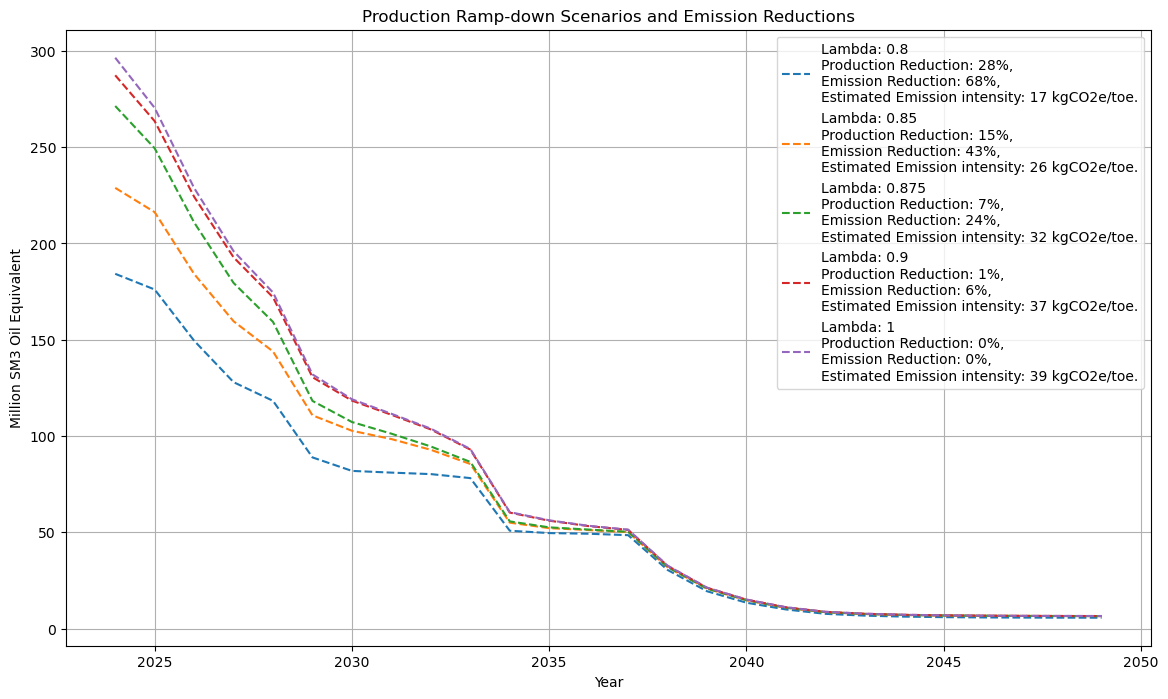

In [552]:
import matplotlib.pyplot as plt
import math


def plot_yearly_production_emissions(results, lambdas, field_pred_data_lifetime):
    # Calculate baseline emissions (all fields open)
    baseline_yearly_emissions = field_pred_data_lifetime.groupby("year")[
        "predicted_emissions"
    ].sum()
    baseline_total_emissions = baseline_yearly_emissions.sum() * 0.84

    # Calculate baseline production (all fields open)
    baseline_yearly_production = field_pred_data_lifetime.groupby("year")[
        "predicted_production"
    ].sum()
    baseline_total_production = baseline_yearly_production.sum()

    # Calculate baseline production (all fields open)
    baseline_yearly_production = field_pred_data_lifetime.groupby("year")[
        "predicted_production"
    ].sum()

    plt.figure(figsize=(14, 8))

    # Iterate over the results for each lambda
    for lambda_ in lambdas:
        df = results[lambda_]
        fields_open = df[df["optimized_production"] > 0]["field"].unique()

        # Extract yearly data for open fields
        yearly_data = field_pred_data_lifetime[
            field_pred_data_lifetime["field"].isin(fields_open)
        ]

        # Sum the production and emissions for each year
        yearly_production = yearly_data.groupby("year")["predicted_production"].sum()
        yearly_emissions = (
            yearly_data.groupby("year")["predicted_emissions"].sum() * 0.84
        )

        # Calculate total emissions for the current lambda
        total_emissions = yearly_emissions.sum()
        total_production = yearly_production.sum()

        # Calculate emission reduction
        emission_reduction = np.round(
            ((baseline_total_emissions - total_emissions) / baseline_total_emissions)
            * 100,
            1,
        )

        # Calculate production reduction
        production_reduction = np.round(
            ((baseline_total_production - total_production) / baseline_total_production)
            * 100,
            1,
        )

        # Calculate the emission intensity
        emission_intensity = np.round(
            total_emissions / (total_production * 100) if total_production != 0 else 0,
            1,
        )

        # Plot production volumes
        plt.plot(
            yearly_production.index,
            yearly_production.values,
            label=f"Lambda: {lambda_}\nProduction Reduction: {math.trunc(production_reduction)}%,\nEmission Reduction: {math.trunc(emission_reduction)}%,\nEstimated Emission intensity: {math.trunc(emission_intensity)} kgCO2e/toe.",
            linestyle="--",
        )

        # Plot emissions
        # plt.plot(yearly_emissions.index, yearly_emissions.values, label=f'Emissions (λ={lambda_}, Reduction: {emission_reduction:.2f}%)', linestyle='--')

    # Add labels and legend
    plt.xlabel("Year")
    plt.ylabel("Million SM3 Oil Equivalent")
    plt.title("Production Ramp-down Scenarios and Emission Reductions")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_yearly_production_emissions(results, lambdas, field_pred_data_lifetime)

In [553]:
# Printing the Fields to shut down for the different lambda values


def print_fields_to_close(results, lambdas):
    for lambda_ in lambdas:
        df = results[lambda_]
        fields_closed = df[df["optimized_production"] == 0]["field"].unique()
        num_fields_closed = len(fields_closed)
        print(f"Lambda = {lambda_}:")
        print(f"Number of fields closed: {num_fields_closed}")
        print(f"Fields closed: {fields_closed}")
        print("\n")


print_fields_to_close(results, lambdas)


Lambda = 0.8:
Number of fields closed: 49
Fields closed: ['alve' 'balder' 'bauge' 'brage' 'draugen' 'dvalin' 'ekofisk' 'eldfisk'
 'fenja' 'gimle' 'gina krog' 'gudrun' 'gullfaks' 'gullfaks sør' 'gungne'
 'heidrun' 'hyme' 'kristin' 'marulk' 'mikkel' 'morvin' 'njord' 'norne'
 'oda' 'oseberg' 'oseberg sør' 'oseberg øst' 'rev' 'sigyn' 'skuld'
 'sleipner vest' 'sleipner øst' 'snorre' 'statfjord' 'statfjord nord'
 'statfjord øst' 'sygna' 'tor' 'tordis' 'trestakk' 'tune' 'ula' 'urd'
 'utgard' 'vigdis' 'vilje' 'visund' 'visund sør' 'yme']


Lambda = 0.85:
Number of fields closed: 34
Fields closed: ['alve' 'brage' 'ekofisk' 'eldfisk' 'gimle' 'gina krog' 'gudrun'
 'gullfaks' 'hyme' 'marulk' 'morvin' 'njord' 'norne' 'oda' 'oseberg'
 'oseberg sør' 'oseberg øst' 'rev' 'sigyn' 'skuld' 'statfjord'
 'statfjord nord' 'statfjord øst' 'sygna' 'tor' 'tordis' 'trestakk' 'tune'
 'ula' 'urd' 'utgard' 'visund' 'visund sør' 'yme']


Lambda = 0.875:
Number of fields closed: 20
Fields closed: ['alve' 'brage' 'eld

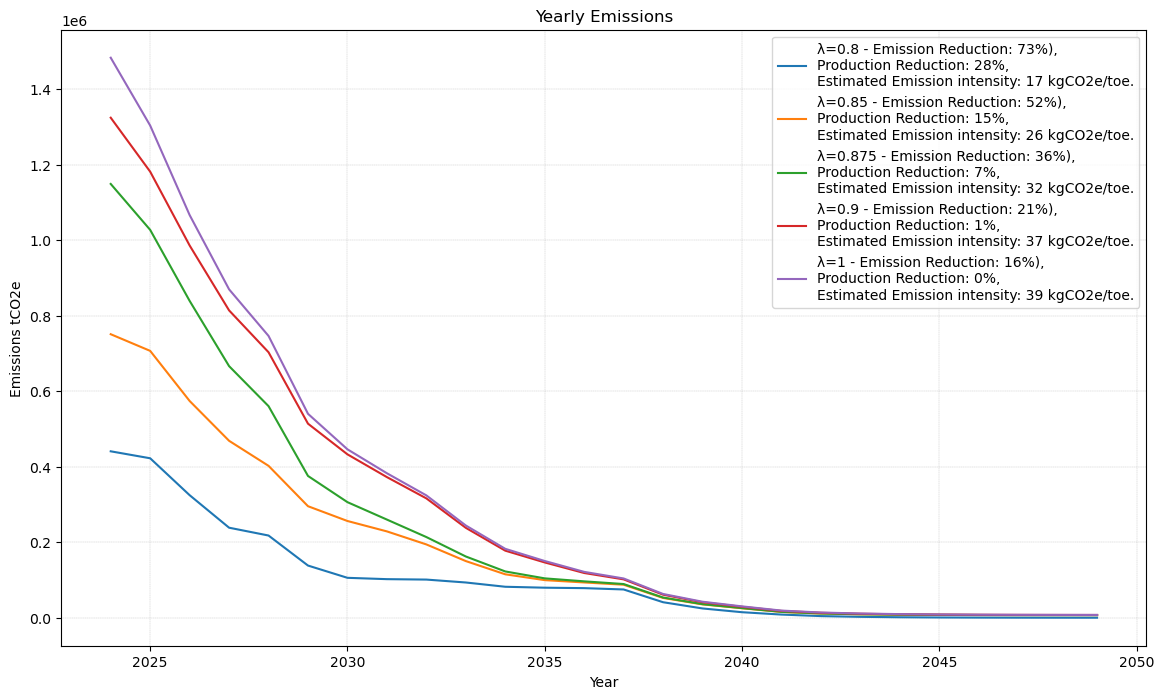

In [554]:
def plot_yearly_production_emissions(results, lambdas, field_pred_data_lifetime):
    # Calculate baseline emissions (all fields open)
    baseline_yearly_emissions = field_pred_data_lifetime.groupby("year")[
        "predicted_emissions"
    ].sum()
    baseline_total_emissions = baseline_yearly_emissions.sum()

    # Calculate baseline production (all fields open)
    baseline_yearly_production = field_pred_data_lifetime.groupby("year")[
        "predicted_production"
    ].sum()
    baseline_total_production = baseline_yearly_production.sum()

    # Calculate baseline production (all fields open)
    baseline_yearly_production = field_pred_data_lifetime.groupby("year")[
        "predicted_production"
    ].sum()

    plt.figure(figsize=(14, 8))

    # Iterate over the results for each lambda
    for lambda_ in lambdas:
        df = results[lambda_]
        fields_open = df[df["optimized_production"] > 0]["field"].unique()

        # Extract yearly data for open fields
        yearly_data = field_pred_data_lifetime[
            field_pred_data_lifetime["field"].isin(fields_open)
        ]

        # Sum the production and emissions for each year
        yearly_production = yearly_data.groupby("year")["predicted_production"].sum()
        yearly_emissions = (
            yearly_data.groupby("year")["predicted_emissions"].sum() * 0.84
        )

        # Calculate total emissions for the current lambda
        total_emissions = yearly_emissions.sum()
        total_production = yearly_production.sum()

        # Calculate emission reduction
        emission_reduction = np.round(
            ((baseline_total_emissions - total_emissions) / baseline_total_emissions)
            * 100,
            1,
        )

        # Calculate production reduction
        production_reduction = np.round(
            ((baseline_total_production - total_production) / baseline_total_production)
            * 100,
            1,
        )

        # Calculate the emission intensity
        emission_intensity = np.round(
            total_emissions / (total_production * 100) if total_production != 0 else 0,
            1,
        )

        # Plot emissions
        plt.plot(
            yearly_emissions.index,
            yearly_emissions.values,
            label=f"λ={lambda_} - Emission Reduction: {math.trunc(emission_reduction)}%),\nProduction Reduction: {math.trunc(production_reduction)}%,\nEstimated Emission intensity: {math.trunc(emission_intensity)} kgCO2e/toe.",
            linestyle="-",
        )

    # Add labels and legend
    plt.xlabel("Year")
    plt.ylabel("Emissions tCO2e")
    plt.title("Yearly Emissions")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.25)

    plt.show()


plot_yearly_production_emissions(results, lambdas, field_pred_data_lifetime)

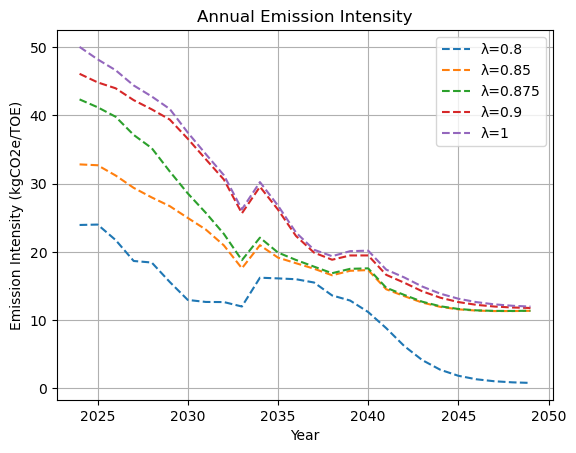

In [555]:
# Plotting the annual emission intensity for the fields


def plot_annual_emission_intensity(results, lambdas, field_pred_data_lifetime):
    constant = 0
    for lambda_ in lambdas:
        df = results[lambda_]
        fields_open = df[df["optimized_production"] > 0]["field"].unique()

        # Extract yearly data for open fields
        yearly_data = field_pred_data_lifetime[
            field_pred_data_lifetime["field"].isin(fields_open)
        ]

        # Sum the production and emissions for each year
        yearly_production = yearly_data.groupby("year")["predicted_production"].sum()
        yearly_emissions = (
            yearly_data.groupby("year")["predicted_emissions"].sum() * 0.84
        )

        # Calculate emission intensity
        emission_intensity = yearly_emissions / (yearly_production * 100)

        if emission_intensity.iloc[0] > constant:
            constant = emission_intensity.iloc[0]

        # Plot emission intensity
        plt.plot(
            emission_intensity.index,
            emission_intensity.values,
            label=f"λ={lambda_}",
            linestyle="--",
        )

    # Add labels and legend
    plt.xlabel("Year")
    plt.ylabel("Emission Intensity (kgCO2e/TOE)")
    plt.title("Annual Emission Intensity")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_annual_emission_intensity(results, lambdas, field_pred_data_lifetime)


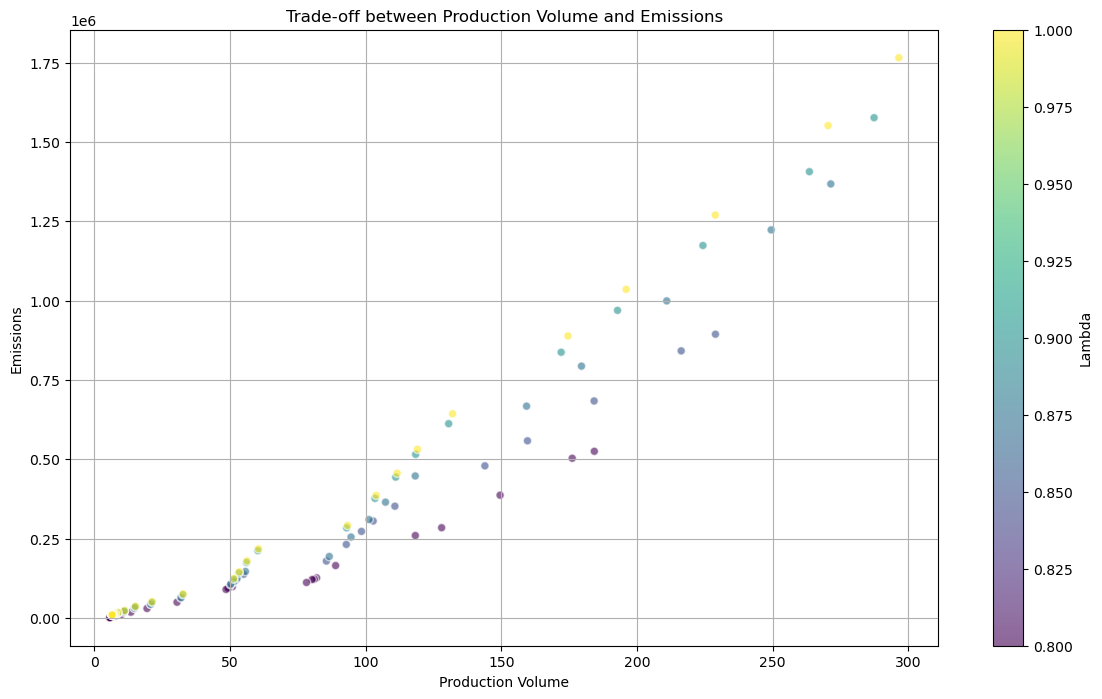

In [556]:
def plot_scatter_tradeoff(results, lambdas, field_pred_data_lifetime):
    data_points = []

    for lambda_ in lambdas:
        df = results[lambda_]
        fields_open = df[df["optimized_production"] > 0]["field"].unique()

        # Extract yearly data for open fields
        yearly_data = field_pred_data_lifetime[
            field_pred_data_lifetime["field"].isin(fields_open)
        ]

        # Sum the production and emissions for each year
        yearly_production = yearly_data.groupby("year")["predicted_production"].sum()
        yearly_emissions = yearly_data.groupby("year")["predicted_emissions"].sum()

        for year in yearly_production.index:
            data_points.append(
                (year, yearly_production[year], yearly_emissions[year], lambda_)
            )

    # Convert to DataFrame for plotting
    plot_df = pd.DataFrame(
        data_points, columns=["Year", "Production", "Emissions", "Lambda"]
    )

    plt.figure(figsize=(14, 8))
    scatter = plt.scatter(
        plot_df["Production"],
        plot_df["Emissions"],
        c=plot_df["Lambda"],
        cmap="viridis",
        alpha=0.6,
        edgecolors="w",
    )
    plt.xlabel("Production Volume")
    plt.ylabel("Emissions")
    plt.title("Trade-off between Production Volume and Emissions")
    cbar = plt.colorbar(scatter)
    cbar.set_label("Lambda")
    plt.grid(True)
    plt.show()


plot_scatter_tradeoff(results, lambdas, field_pred_data_lifetime)

In [557]:
# Checking the total production volume in 2021

field_data[field_data["year"] == "2021"]["net_oil_eq_prod_yearly_mill_sm3"].sum()
field_data[field_data["year"] == "2021"]["net_oil_eq_prod_yearly_mill_sm3"].sum()

232.93925000000002

In [558]:
field_data

,field,year,net_oil_prod_yearly_mill_sm3,net_gas_prod_yearly_bill_sm3,net_ngl_prod_yearly_mill_sm3,net_condensate_prod_yearly_mill_sm3,net_oil_eq_prod_yearly_mill_sm3,produced_water_yearly_mill_sm3,field_id,net_oil_prod_monthly_sm3_volatility,net_gas_prod_monthly_sm3_volatility,net_ngl_prod_monthly_sm3_volatility,net_condensate_prod_monthly_sm3_volatility,net_oil_eq_prod_monthly_sm3_volatility,produced_water_in_field_volatility,status,current_status,field_owner,processing_field,field_in_emissions,facilities_lifetime_mean,facilities_lifetime_std,facilities_water_depth_mean,facilities_water_depth_std,subsea_facilites_shut_down,surface_facilites_shut_down,subsea_facilites_in_service,surface_facilites_in_service,facility_kind_multi well template,facility_kind_single well template,facility_kind_offshore wind turbine,facility_kind_subsea structure,facility_kind_fpso,facility_kind_jacket 8 legs,facility_kind_condeep monoshaft,facility_kind_loading system,facility_kind_jacket 4 legs,facility_kind_jacket tripod,facility_kind_fsu,facility_kind_semisub steel,facility_kind_condeep 4 shafts,facility_kind_landfall,facility_kind_tlp concrete,facility_kind_jack-up 3 legs,facility_kind_jacket 6 legs,facility_kind_tlp steel,facility_kind_semisub concrete,facility_kind_mopustor,facility_kind_spar,well_status_closed,well_status_drilling,well_status_injecting,well_status_junked,well_status_online/operational,well_status_p&a,well_status_plugged,well_status_producing,well_status_suspended,well_purpose_injection,well_purpose_observation,well_purpose_production,well_subsea_no,well_subsea_yes,well_final_vertical_depth_mean,well_final_vertical_depth_std,well_water_depth_mean,well_water_depth_std,investments_mill_nok,future_investments_mill_nok,yearly_co2_emissions_1000_tonnes,org_number,operator,yearly_ch4_emissions_tons,yearly_nox_emissions_tons,yearly_oil_spill_emissions_tons,yearly_water_emissions_m3,ownership_original,ownership_new_name,current_remaining_recoverable_oil,current_remaining_recoverable_gas,current_remaining_recoverable_ngl,current_remaining_recoverable_condensate,current_remaining_recoverable_oe,original_recoverable_oil,original_recoverable_gas,original_recoverable_ngl,original_recoverable_condensate,original_recoverable_oe
0,statfjord nord,1997-01-01,3.93531,0.17288,0.09230,0.00000,4.20051,0.00000,43679,0.053898,0.000405,0.000334,0.000000,0.054005,0.000000,Producing,Producing,21084.0,statfjord,True,27.5,15.0,241.75,65.030121,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,6.0,9.0,0.0,4.0,0.0,13.0,0.0,17.0,2888.8,0.000000,285.000000,0.000000,255.0,2946.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Den norske stats oljeselskap a.s': 50.0, 'Mo...","{'Equinor ASA': 1.875, 'Mobil Development Norw...",3.72,0.23,0.05,0.0,4.05,44.12,2.37,1.12,0.00,48.62
1,veslefrikk,1997-01-01,3.47468,0.13919,0.08596,0.00000,3.69981,0.00000,43618,0.052851,0.008952,0.005461,0.000000,0.053418,0.000000,Producing,Shut down,21212.0,veslefrikk,True,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111.0,0.0,0.0,69.0,6.0,36.0,111.0,0.0,3317.0,0.000000,175.000000,0.000000,229.0,0.0,156.204920,993246905.0,equinor energy as,64.319881,973.466100,88.599389,2.782760e+06,"{'Den norske stats oljeselskap a.s': 55.0, 'To...","{'Equinor ASA': 55.0, 'TotalEnergies EP Norge'...",0.00,0.00,0.00,0.0,0.00,55.34,4.19,1.81,0.00,62.97
2,frøy,1997-01-01,1.39602,0.28878,0.00000,0.01732,1.70211,0.00000,43597,0.026260,0.005287,0.000000,0.000942,0.030860,0.000000,Producing,Shut down,3810636.0,frigg,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,6.0,0.0,6.0,12.0,0.0,3352.2,70.481913,120.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Den norske stats oljeselskap a.s': 53.96, 'T...","{'Equinor ASA': 53.96, 'TotalEnergies EP 

In [559]:
lifetime_pred_df

,field,total_lifetime_emissions,total_lifetime_production,total_lifetime_electrified_emissions,geometry,scaled_lifetime_production,scaled_lifetime_emissions,scaled_electrified_emissions
0,aasta hansteen,58187.173417,21.040000,346.872795,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",0.033637,0.050467,0.000301
1,alve,58908.461045,4.118687,286.706045,"MULTIPOLYGON (((7.80611 65.97710, 7.80625 65.9...",0.006526,0.051093,0.000249
2,alvheim,147909.076742,20.350000,752.269087,"MULTIPOLYGON (((1.86880 59.55038, 1.87198 59.5...",0.032531,0.128317,0.000653
3,balder,232988.695910,28.040000,1155.084645,"MULTIPOLYGON (((2.37593 59.15121, 2.37463 59.1...",0.044852,0.202138,0.001002
4,bauge,62587.901941,6.320976,330.082263,"POLYGON ((7.44684 64.33341, 7.44352 64.33401, ...",0.010054,0.054285,0.000286
...,...,...,...,...,...,...,...,...
80,visund sør,11252.092243,0.960281,54.833176,"POLYGON ((2.33555 61.27199, 2.33086 61.27331, ...",0.001465,0.009743,0.000047
81,volund,5082.142955,0.780000,24.043655,"POLYGON ((2.00307 59.44880, 1.99984 59.45090, ...",0.001176,0.004389,0.000021
82,yme,110375.673089,6.448206,567.698452,"MULTIPOLYGON (((4.54792 57.77684, 4.53891 57.7...",0.010258,0.095750,0.000492
83,åsgard,307661.986007,42.790000,1700.871017,"MULTIPOLYGON (((6.96310 65.22484, 6.96319 65.2...",0.068485,0.266930,0.001476


In [560]:
lifetime_pred_df

,field,total_lifetime_emissions,total_lifetime_production,total_lifetime_electrified_emissions,geometry,scaled_lifetime_production,scaled_lifetime_emissions,scaled_electrified_emissions
0,aasta hansteen,58187.173417,21.040000,346.872795,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",0.033637,0.050467,0.000301
1,alve,58908.461045,4.118687,286.706045,"MULTIPOLYGON (((7.80611 65.97710, 7.80625 65.9...",0.006526,0.051093,0.000249
2,alvheim,147909.076742,20.350000,752.269087,"MULTIPOLYGON (((1.86880 59.55038, 1.87198 59.5...",0.032531,0.128317,0.000653
3,balder,232988.695910,28.040000,1155.084645,"MULTIPOLYGON (((2.37593 59.15121, 2.37463 59.1...",0.044852,0.202138,0.001002
4,bauge,62587.901941,6.320976,330.082263,"POLYGON ((7.44684 64.33341, 7.44352 64.33401, ...",0.010054,0.054285,0.000286
...,...,...,...,...,...,...,...,...
80,visund sør,11252.092243,0.960281,54.833176,"POLYGON ((2.33555 61.27199, 2.33086 61.27331, ...",0.001465,0.009743,0.000047
81,volund,5082.142955,0.780000,24.043655,"POLYGON ((2.00307 59.44880, 1.99984 59.45090, ...",0.001176,0.004389,0.000021
82,yme,110375.673089,6.448206,567.698452,"MULTIPOLYGON (((4.54792 57.77684, 4.53891 57.7...",0.010258,0.095750,0.000492
83,åsgard,307661.986007,42.790000,1700.871017,"MULTIPOLYGON (((6.96310 65.22484, 6.96319 65.2...",0.068485,0.266930,0.001476


In [561]:
lambdas

[0.8, 0.85, 0.875, 0.9, 1]

In [599]:
def optimize_electrification(df, lambdas, electrification_levels):
    results = {}

    for electrification_level in electrification_levels:
        num_fields = len(df)
        print(len(df))
        num_electrified_fields = int(electrification_level * num_fields / 100)

        for lambda_ in lambdas:
            # Create the OR-Tools solver
            solver = pywraplp.Solver.CreateSolver("SCIP")
            if not solver:
                raise Exception("Solver not created.")

            # Create binary decision variables for electrification
            e = [solver.BoolVar(f"e_{i}") for i in range(num_fields)]

            # Objective function: Maximize production and minimize emissions
            objective = solver.Objective()
            for i in range(num_fields):
                # Adjusted emissions
                adjusted_emissions = (
                    e[i] * df["total_lifetime_electrified_emissions"][i]
                    + (1 - e[i]) * df["total_lifetime_emissions"][i]
                )
                # Set the coefficients for the objective
                objective.SetCoefficient(
                    e[i], lambda_ * df["total_lifetime_production"][i]
                )
                objective.SetCoefficient(
                    e[i], -(1 - lambda_) * df["total_lifetime_electrified_emissions"][i]
                )
                objective.SetCoefficient(
                    e[i], (1 - lambda_) * df["total_lifetime_emissions"][i]
                )
            objective.SetMaximization()

            # Constraint: Number of electrified fields should match the specified electrification level
            solver.Add(solver.Sum(e) == num_electrified_fields)

            # Solve the problem
            status = solver.Solve()

            # Check if a solution has been found
            if status == pywraplp.Solver.OPTIMAL:
                print(
                    f"Optimal solution found for lambda = {lambda_} and electrification level = {electrification_level}%."
                )
            elif status == pywraplp.Solver.FEASIBLE:
                print(
                    f"A potentially suboptimal solution was found for lambda = {lambda_} and electrification level = {electrification_level}%."
                )
            else:
                print(
                    f"No solution found for lambda = {lambda_} and electrification level = {electrification_level}%."
                )
                continue

            # Get the results
            electrification_decisions = [
                e[i].solution_value() for i in range(num_fields)
            ]

            # Calculate optimized emissions
            optimized_emissions = (
                np.array(electrification_decisions)
                * df["total_lifetime_electrified_emissions"]
                + (1 - np.array(electrification_decisions))
                * df["total_lifetime_emissions"]
            )

            # Calculate optimized production (should remain the same since electrification doesn't affect production directly)
            optimized_production = df["total_lifetime_production"]

            # Create a result DataFrame for the current lambda and electrification level
            result_df = df.copy()
            result_df["optimized_production"] = optimized_production
            result_df["optimized_emissions"] = optimized_emissions
            result_df["electrification_decision"] = electrification_decisions

            # Add the result DataFrame to the results dictionary
            results[(lambda_, electrification_level)] = result_df

    return results


electrification_levels = [0, 5, 10, 15, 20, 30, 40, 50]
lambdas = [0.8, 0.85, 0.875, 0.9, 1]

results_with_electrification = optimize_electrification(
    df, lambdas, electrification_levels
)


# Function to print fields to electrify for each combination of lambda and electrification level
def print_fields_to_electrify(results, lambdas, electrification_levels):
    for lambda_ in lambdas:
        for electrification_level in electrification_levels:
            df = results[(lambda_, electrification_level)]
            fields_electrified = df[df["electrification_decision"] == 1][
                "field"
            ].unique()
            num_fields_electrified = len(fields_electrified)

            print(
                f"Lambda = {lambda_}, Electrification Level = {electrification_level}%:"
            )
            print(f"Number of fields electrified: {num_fields_electrified}")
            print(f"Fields electrified: {fields_electrified}")
            print("\n")


print_fields_to_electrify(results_with_electrification, lambdas, electrification_levels)

85
Optimal solution found for lambda = 0.8 and electrification level = 0%.
Optimal solution found for lambda = 0.85 and electrification level = 0%.
Optimal solution found for lambda = 0.875 and electrification level = 0%.
Optimal solution found for lambda = 0.9 and electrification level = 0%.
Optimal solution found for lambda = 1 and electrification level = 0%.
85
Optimal solution found for lambda = 0.8 and electrification level = 5%.
Optimal solution found for lambda = 0.85 and electrification level = 5%.
Optimal solution found for lambda = 0.875 and electrification level = 5%.
Optimal solution found for lambda = 0.9 and electrification level = 5%.
Optimal solution found for lambda = 1 and electrification level = 5%.
85
Optimal solution found for lambda = 0.8 and electrification level = 10%.
Optimal solution found for lambda = 0.85 and electrification level = 10%.
Optimal solution found for lambda = 0.875 and electrification level = 10%.
Optimal solution found for lambda = 0.9 and ele

In [601]:
df_2 = df.copy()

electrified_field_names = field_pred_data[field_pred_data["electrified"] == 1][
    "field"
].unique()
# adding a column for electrified from field_pred_data_lifetime

df_2["electrified"] = df_2["field"].apply(
    lambda x: 1 if x in electrified_field_names else 0
)

df_2


# Remove all fields that are already electrified

df_2 = df_2[df_2["electrified"] == 0]

# drop the electrified column

df_2 = df_2.drop(columns=["electrified"])

# reset index
df_2 = df_2.reset_index(drop=True)


In [617]:
def optimize_electrification_2(df, lambdas, electrification_levels):
    results = {}

    for electrification_level in electrification_levels:
        num_fields = len(df)
        print(len(df))
        num_electrified_fields = int(electrification_level * num_fields / 100)

        for lambda_ in lambdas:
            # Create the OR-Tools solver
            solver = pywraplp.Solver.CreateSolver("SCIP")
            if not solver:
                raise Exception("Solver not created.")

            # Create binary decision variables for electrification
            e = [solver.BoolVar(f"e_{i}") for i in range(num_fields)]

            # Objective function: Maximize production and minimize emissions
            objective = solver.Objective()
            for i in range(num_fields):
                # Adjusted emissions
                adjusted_emissions = (
                    e[i] * df["total_lifetime_electrified_emissions"][i]
                    + (1 - e[i]) * df["total_lifetime_emissions"][i]
                )
                # Set the coefficients for the objective
                objective.SetCoefficient(
                    e[i], lambda_ * df["total_lifetime_production"][i]
                )
                objective.SetCoefficient(
                    e[i], -(1 - lambda_) * df["total_lifetime_electrified_emissions"][i]
                )
                objective.SetCoefficient(
                    e[i], (1 - lambda_) * df["total_lifetime_emissions"][i]
                )
            objective.SetMaximization()

            # Constraint: Number of electrified fields should match the specified electrification level
            solver.Add(solver.Sum(e) == num_electrified_fields)

            # Solve the problem
            status = solver.Solve()

            # Check if a solution has been found
            if status == pywraplp.Solver.OPTIMAL:
                print(
                    f"Optimal solution found for lambda = {lambda_} and electrification level = {electrification_level}%."
                )
            elif status == pywraplp.Solver.FEASIBLE:
                print(
                    f"A potentially suboptimal solution was found for lambda = {lambda_} and electrification level = {electrification_level}%."
                )
            else:
                print(
                    f"No solution found for lambda = {lambda_} and electrification level = {electrification_level}%."
                )
                continue

            # Get the results
            electrification_decisions = [
                e[i].solution_value() for i in range(num_fields)
            ]

            # Calculate optimized emissions
            optimized_emissions = (
                np.array(electrification_decisions)
                * df["total_lifetime_electrified_emissions"]
                + (1 - np.array(electrification_decisions))
                * df["total_lifetime_emissions"]
            )

            # Calculate optimized production (should remain the same since electrification doesn't affect production directly)
            optimized_production = df["total_lifetime_production"]

            # Create a result DataFrame for the current lambda and electrification level
            result_df = df.copy()
            result_df["optimized_production"] = optimized_production
            result_df["optimized_emissions"] = optimized_emissions
            result_df["electrification_decision"] = electrification_decisions

            # Add the result DataFrame to the results dictionary
            results[(lambda_, electrification_level)] = result_df

    return results


electrification_levels = [0, 5, 10, 15, 20, 30, 40, 50]
lambdas = [0.1, 0.8, 0.85, 0.875, 1]

results_with_electrification_2 = optimize_electrification_2(
    df=df_2, lambdas=lambdas, electrification_levels=electrification_levels
)


# Function to print fields to electrify for each combination of lambda and electrification level
def print_fields_to_electrify(results, lambdas, electrification_levels):
    for lambda_ in lambdas:
        for electrification_level in electrification_levels:
            df = results[(lambda_, electrification_level)]
            fields_electrified = df[df["electrification_decision"] == 1][
                "field"
            ].unique()
            num_fields_electrified = len(fields_electrified)

            print(
                f"Lambda = {lambda_}, Electrification Level = {electrification_level}%:"
            )
            print(f"Number of fields electrified: {num_fields_electrified}")
            print(f"Fields electrified: {fields_electrified}")
            print("\n")


print_fields_to_electrify(
    results_with_electrification_2, lambdas, electrification_levels
)


67
Optimal solution found for lambda = 0.1 and electrification level = 0%.
Optimal solution found for lambda = 0.8 and electrification level = 0%.
Optimal solution found for lambda = 0.85 and electrification level = 0%.
Optimal solution found for lambda = 0.875 and electrification level = 0%.
Optimal solution found for lambda = 1 and electrification level = 0%.
67
Optimal solution found for lambda = 0.1 and electrification level = 5%.
Optimal solution found for lambda = 0.8 and electrification level = 5%.
Optimal solution found for lambda = 0.85 and electrification level = 5%.
Optimal solution found for lambda = 0.875 and electrification level = 5%.
Optimal solution found for lambda = 1 and electrification level = 5%.
67
Optimal solution found for lambda = 0.1 and electrification level = 10%.
Optimal solution found for lambda = 0.8 and electrification level = 10%.
Optimal solution found for lambda = 0.85 and electrification level = 10%.
Optimal solution found for lambda = 0.875 and ele

In [576]:
field_pred_data

,field,year,predicted_production,cumulative_production,predicted_emissions,years_left,reserve,mean_emission_intensity_distributed,electrified,geometry
0,statfjord nord,2024,1.542401,1.542401,31905.685669,3.0,4.050000,164.031554,0,"MULTIPOLYGON (((1.99934 61.46574, 2.00438 61.4..."
1,statfjord nord,2025,1.542401,3.084802,32328.536506,2.0,2.507599,164.031554,0,"MULTIPOLYGON (((1.99934 61.46574, 2.00438 61.4..."
2,statfjord nord,2026,0.612391,3.697193,13406.403032,1.0,0.965198,164.031554,0,"MULTIPOLYGON (((1.99934 61.46574, 2.00438 61.4..."
3,statfjord nord,2027,0.223846,3.921039,4988.220807,0.0,0.352807,164.031554,0,"MULTIPOLYGON (((1.99934 61.46574, 2.00438 61.4..."
4,statfjord nord,2028,0.081822,4.002861,1835.171342,0.0,0.128961,164.031554,0,"MULTIPOLYGON (((1.99934 61.46574, 2.00438 61.4..."
...,...,...,...,...,...,...,...,...,...,...
1319,fenja,2031,0.889540,7.116320,8704.090423,3.0,2.853220,87.033573,0,"POLYGON ((6.77833 64.04353, 6.77841 64.04355, ..."
1320,fenja,2032,0.889540,8.005860,8983.287469,2.0,1.963680,87.033573,0,"POLYGON ((6.77833 64.04353, 6.77841 64.04355, ..."
1321,fenja,2033,0.889540,8.895400,9308.647692,1.0,1.074140,87.033573,0,"POLYGON ((6.77833 64.04353, 6.77841 64.04355, ..."
1322,fenja,2034,0.334779,9.230179,3841.613227,0.0,0.184600,87.033573,0,"POLYGON ((6.77833 64.04353, 6.77841 64.04355, ..."


In [ ]:
results_with_electrification

{(0.5,
  0):              field  total_lifetime_emissions  total_lifetime_production  \
 0   aasta hansteen              58187.173417                  21.040000   
 1             alve              58908.461045                   4.118687   
 2          alvheim             147909.076742                  20.350000   
 3           balder             232988.695910                  28.040000   
 4            bauge              62587.901941                   6.320976   
 ..             ...                       ...                        ...   
 80      visund sør              11252.092243                   0.960281   
 81          volund               5082.142955                   0.780000   
 82             yme             110375.673089                   6.448206   
 83          åsgard             307661.986007                  42.790000   
 84     ærfugl nord               3256.857656                   0.720000   
 
     total_lifetime_electrified_emissions  \
 0                           

In [ ]:
def check_electrified_fields_consistency(results, lambdas, electrification_levels):
    for electrification_level in electrification_levels:
        # Initialize a dictionary to store the electrified fields for each lambda
        electrified_fields_dict = {}

        for lambda_ in lambdas:
            df = results[(lambda_, electrification_level)]
            fields_electrified = set(
                df[df["electrification_decision"] == 1]["field"].unique()
            )
            electrified_fields_dict[lambda_] = fields_electrified

        # Compare the sets of electrified fields across different lambdas
        reference_lambda = lambdas[0]
        reference_fields = electrified_fields_dict[reference_lambda]

        consistency_flag = True

        # Printing the fields to electrify for each lambda
        print(
            f"Fields to electrify for electrification level {electrification_level}%:"
        )
        for lambda_, fields in electrified_fields_dict.items():
            print(f"Lambda {lambda_}: {fields}")

        for lambda_ in lambdas[1:]:
            if electrified_fields_dict[lambda_] != reference_fields:
                consistency_flag = False
                print(
                    f"Inconsistency found for electrification level {electrification_level}% between lambda {reference_lambda} and lambda {lambda_}."
                )
                print(f"Fields for lambda {reference_lambda}: {reference_fields}")
                print(
                    f"Fields for lambda {lambda_}: {electrified_fields_dict[lambda_]}\n"
                )

        if consistency_flag:
            print(
                f"Electrified fields are consistent across all lambdas for electrification level {electrification_level}%.\n"
            )


check_electrified_fields_consistency(
    results_with_electrification, lambdas, electrification_levels
)

Fields to electrify for electrification level 0%:
Lambda 0.5: set()
Lambda 0.6: set()
Lambda 0.7: set()
Lambda 0.8: set()
Lambda 0.9: set()
Electrified fields are consistent across all lambdas for electrification level 0%.

Fields to electrify for electrification level 5%:
Lambda 0.5: {'snorre', 'oseberg', 'heidrun', 'troll'}
Lambda 0.6: {'snorre', 'oseberg', 'heidrun', 'troll'}
Lambda 0.7: {'snorre', 'oseberg', 'heidrun', 'troll'}
Lambda 0.8: {'snorre', 'oseberg', 'heidrun', 'troll'}
Lambda 0.9: {'snorre', 'oseberg', 'heidrun', 'troll'}
Electrified fields are consistent across all lambdas for electrification level 5%.

Fields to electrify for electrification level 10%:
Lambda 0.5: {'njord', 'visund', 'troll', 'oseberg', 'ekofisk', 'snorre', 'heidrun', 'eldfisk'}
Lambda 0.6: {'njord', 'visund', 'troll', 'oseberg', 'ekofisk', 'snorre', 'heidrun', 'eldfisk'}
Lambda 0.7: {'njord', 'visund', 'troll', 'oseberg', 'ekofisk', 'snorre', 'heidrun', 'eldfisk'}
Lambda 0.8: {'njord', 'visund', 'tro

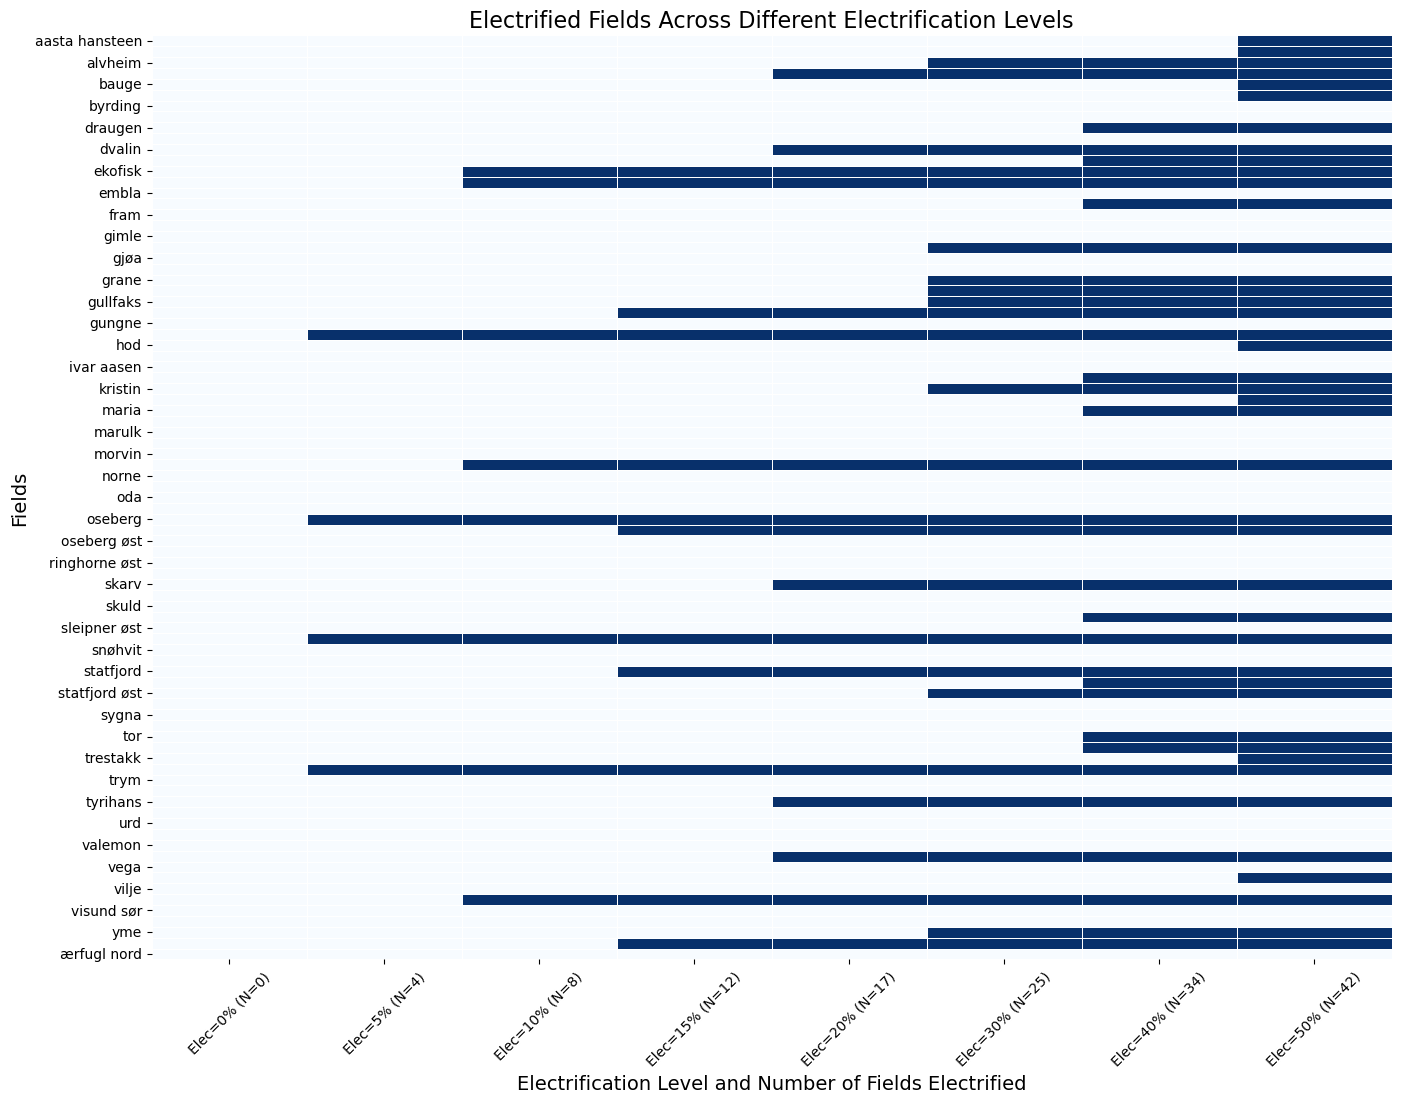

In [603]:
def prepare_heatmap_data_single_lambda(results, lambda_, electrification_levels):
    fields = results[(lambda_, electrification_levels[0])]["field"].unique()
    heatmap_data = pd.DataFrame(index=fields)

    for electrification_level in electrification_levels:
        df = results[(lambda_, electrification_level)]
        electrified = df["electrification_decision"]
        num_fields_electrified = int(electrification_level * len(df) / 100)
        column_name = f"Elec={electrification_level}% (N={num_fields_electrified})"
        heatmap_data[column_name] = electrified.values

    return heatmap_data


def plot_heatmap(heatmap_data, lambda_):
    plt.figure(figsize=(16, 12))
    sns.heatmap(heatmap_data, cmap="Blues", cbar=False, linewidths=0.5)
    plt.title(
        f"Electrified Fields Across Different Electrification Levels",
        fontsize=16,
    )
    plt.xlabel("Electrification Level and Number of Fields Electrified", fontsize=14)
    plt.ylabel("Fields", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()


# Choose the lambda value to display
lambda_to_display = 0.8

# Prepare heatmap data for the chosen lambda
heatmap_data_single_lambda = prepare_heatmap_data_single_lambda(
    results_with_electrification, lambda_to_display, electrification_levels
)

# Plot the heatmap
plot_heatmap(heatmap_data_single_lambda, lambda_to_display)

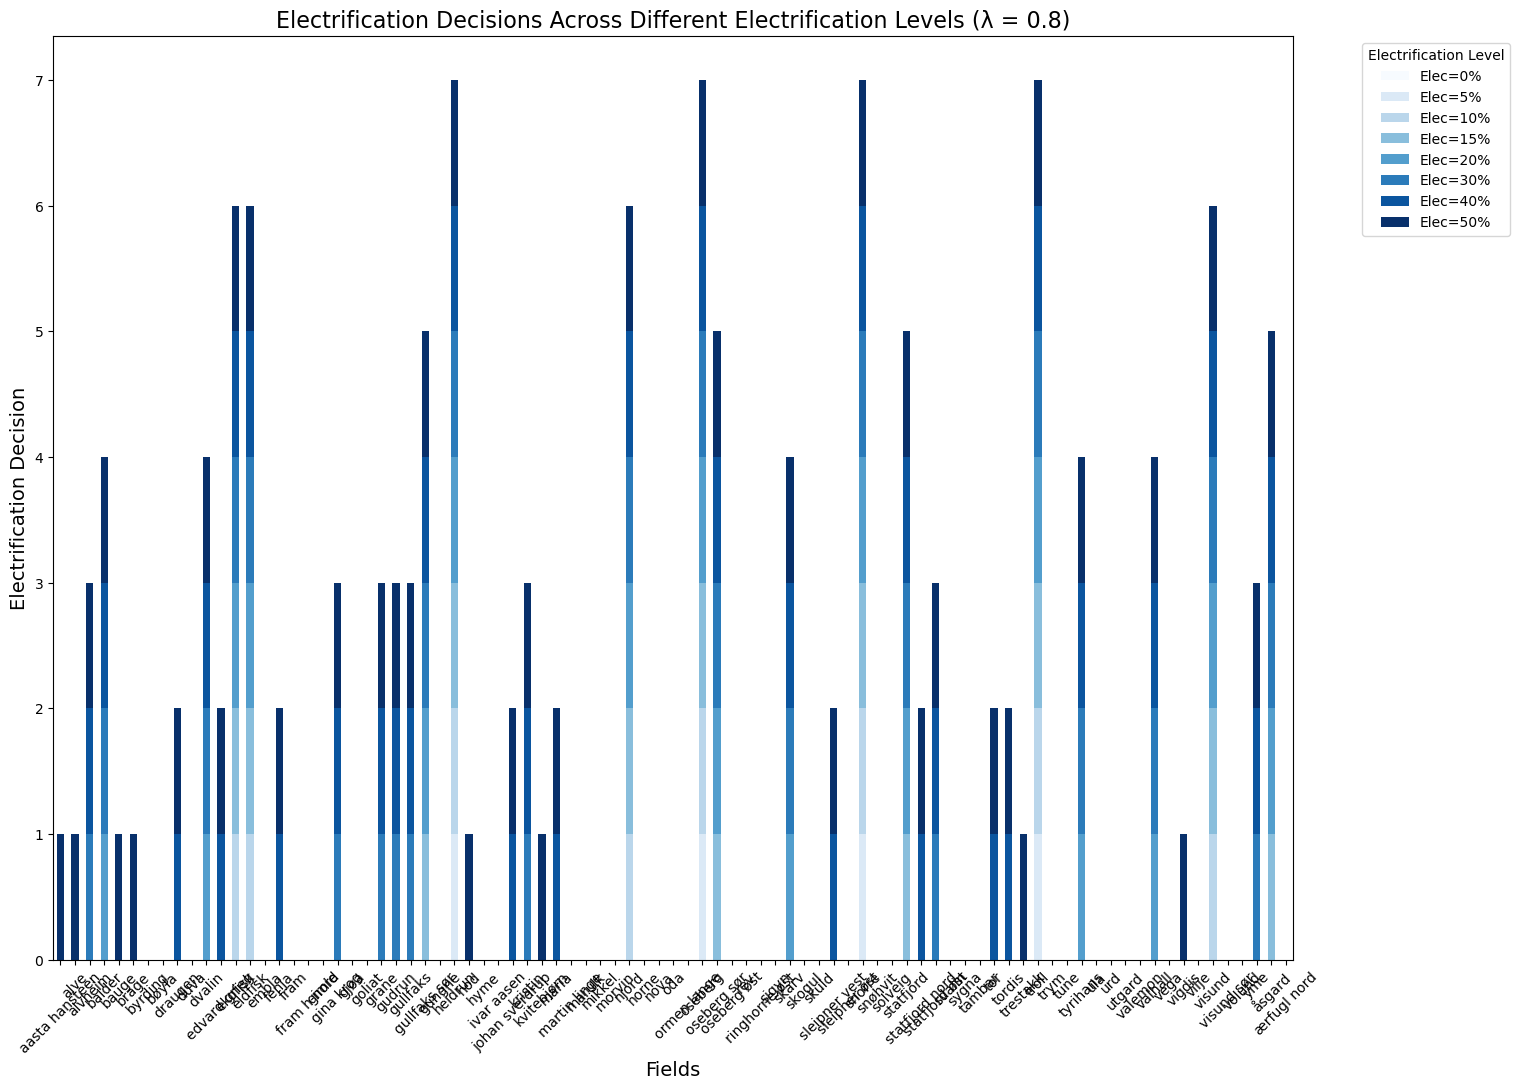

In [604]:
import matplotlib.pyplot as plt


def prepare_bar_chart_data_single_lambda(results, lambda_, electrification_levels):
    fields = results[(lambda_, electrification_levels[0])]["field"].unique()
    bar_chart_data = pd.DataFrame(index=fields)

    for electrification_level in electrification_levels:
        df = results[(lambda_, electrification_level)]
        electrified = df["electrification_decision"]
        column_name = f"Elec={electrification_level}%"
        bar_chart_data[column_name] = electrified.values

    return bar_chart_data


def plot_stacked_bar_chart(bar_chart_data, lambda_):
    bar_chart_data.plot(kind="bar", stacked=True, figsize=(16, 12), colormap="Blues")
    plt.title(
        f"Electrification Decisions Across Different Electrification Levels (λ = {lambda_})",
        fontsize=16,
    )
    plt.xlabel("Fields", fontsize=14)
    plt.ylabel("Electrification Decision", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.legend(
        title="Electrification Level", bbox_to_anchor=(1.05, 1), loc="upper left"
    )
    plt.show()


# Prepare bar chart data for the chosen lambda
bar_chart_data_single_lambda = prepare_bar_chart_data_single_lambda(
    results_with_electrification, lambda_to_display, electrification_levels
)

# Plot the stacked bar chart
plot_stacked_bar_chart(bar_chart_data_single_lambda, lambda_to_display)


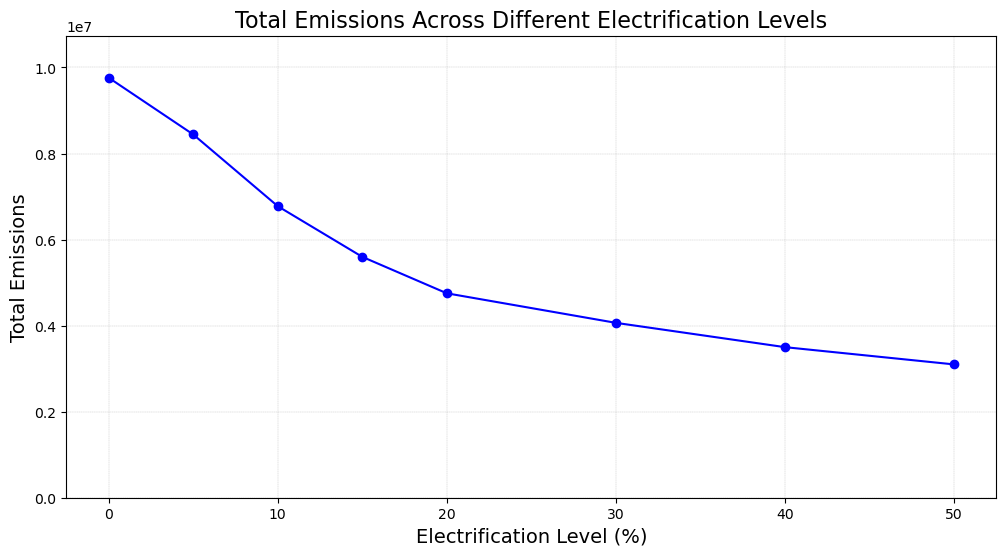

In [615]:
import matplotlib.pyplot as plt


def calculate_total_emissions(results, lambda_, electrification_levels):
    total_emissions = []

    for electrification_level in electrification_levels:
        df = results[(lambda_, electrification_level)]
        total_emissions.append(df["optimized_emissions"].sum())

    return total_emissions


def plot_total_emissions(total_emissions, electrification_levels, lambda_):
    plt.figure(figsize=(12, 6))
    plt.plot(
        electrification_levels, total_emissions, marker="o", linestyle="-", color="b"
    )
    plt.title(f"Total Emissions Across Different Electrification Levels", fontsize=16)
    plt.xlabel("Electrification Level (%)", fontsize=14)
    plt.ylabel("Total Emissions", fontsize=14)
    plt.ylim(0, max(total_emissions) * 1.1)
    plt.grid(True, which="both", linestyle="--", linewidth=0.25)
    plt.show()


# Calculate total emissions for the chosen lambda
lambda_to_display = 0.8
total_emissions = calculate_total_emissions(
    results_with_electrification, lambda_to_display, electrification_levels
)

# Plot the total emissions
plot_total_emissions(total_emissions, electrification_levels, lambda_to_display)

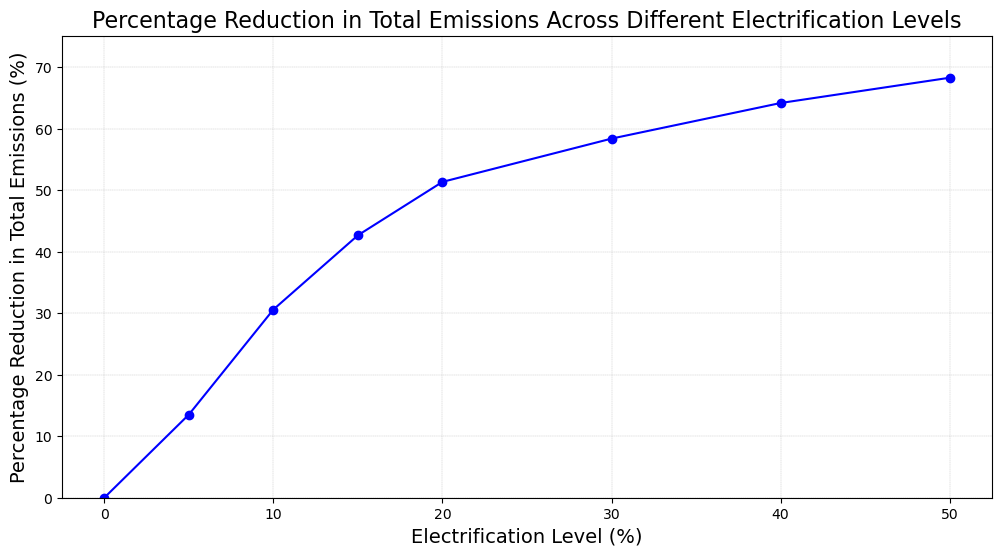

In [616]:
# Show the Y axis as Total Emissions in % reduction for each Eelectrification Level. Use the 0 % electrifitcation level as the baseline

# Calculate the baseline emissions
baseline_emissions = total_emissions[0]

# Calculate the percentage reduction in emissions for each electrification level
percent_reduction = [
    ((baseline_emissions - emissions) / baseline_emissions) * 100
    for emissions in total_emissions
]

# Plot the percentage reduction in emissions
plt.figure(figsize=(12, 6))
plt.plot(
    electrification_levels, percent_reduction, marker="o", linestyle="-", color="b"
)
plt.title(
    "Percentage Reduction in Total Emissions Across Different Electrification Levels",
    fontsize=16,
)
plt.xlabel("Electrification Level (%)", fontsize=14)
plt.ylabel("Percentage Reduction in Total Emissions (%)", fontsize=14)
plt.ylim(0, max(percent_reduction) * 1.1)
plt.grid(True, which="both", linestyle="--", linewidth=0.25)
plt.show()


In [618]:
percent_reduction


[0.0,
 13.511398160652204,
 30.586072330634668,
 42.654769479201185,
 51.33151260406157,
 58.3647999920202,
 64.15290929540308,
 68.25993865804789]

In [ ]:
results_with_electrification[(0.5, 20)].optimized_emissions.sum()

4750643.075863708

In [ ]:
# Adding the optimized_emissions column with the range of lambdas to the lifetime_pred_df as new columns for each lambda

lifetime_pred_optimized_df = lifetime_pred_df.copy()

for lambda_ in lambdas:
    lifetime_pred_optimized_df[f"optimized_emissions_{lambda_}"] = (
        results_with_electrification[(lambda_, 20)].optimized_emissions
    )

lifetime_pred_optimized_df.head(10)

,field,total_lifetime_emissions,total_lifetime_production,total_lifetime_electrified_emissions,geometry,scaled_lifetime_production,scaled_lifetime_emissions,scaled_electrified_emissions,optimized_emissions_0.5,optimized_emissions_0.6,optimized_emissions_0.7,optimized_emissions_0.8,optimized_emissions_0.9
0,aasta hansteen,58187.173417,21.040000,346.872795,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",0.033637,0.050467,3.008763e-04,58187.173417,58187.173417,58187.173417,58187.173417,58187.173417
1,alve,58908.461045,4.118687,286.706045,"MULTIPOLYGON (((7.80611 65.97710, 7.80625 65.9...",0.006526,0.051093,2.486721e-04,58908.461045,58908.461045,58908.461045,58908.461045,58908.461045
2,alvheim,147909.076742,20.350000,752.269087,"MULTIPOLYGON (((1.86880 59.55038, 1.87198 59.5...",0.032531,0.128317,6.526217e-04,147909.076742,147909.076742,147909.076742,147909.076742,147909.076742
3,balder,232988.695910,28.040000,1155.084645,"MULTIPOLYGON (((2.37593 59.15121, 2.37463 59.1...",0.044852,0.202138,1.002128e-03,1155.084645,1155.084645,1155.084645,1155.084645,1155.084645
4,bauge,62587.901941,6.320976,330.082263,"POLYGON ((7.44684 64.33341, 7.44352 64.33401, ...",0.010054,0.054285,2.863078e-04,62587.901941,62587.901941,62587.901941,62587.901941,62587.901941
5,brage,65343.360369,2.180000,293.930082,"POLYGON ((3.03000 60.61612, 3.02991 60.61638, ...",0.003420,0.056676,2.549401e-04,65343.360369,65343.360369,65343.360369,65343.360369,65343.360369
6,byrding,238.529793,0.110000,1.137324,"POLYGON ((3.52820 61.13359, 3.52803 61.13481, ...",0.000103,0.000186,8.960829e-07,238.529793,238.529793,238.529793,238.529793,238.529793
7,bøyla,1799.223357,1.540000,9.244821,"POLYGON ((1.80629 59.33086, 1.80326 59.33172, ...",0.002394,0.001541,7.930619e-06,1799.223357,1799.223357,1799.223357,1799.223357,1799.223357
8,draugen,85383.790086,10.800000,409.192213,"MULTIPOLYGON (((7.71425 64.22451, 7.71274 64.2...",0.017230,0.074065,3.549482e-04,85383.790086,85383.790086,85383.790086,85383.790086,85383.790086
9,duva,8829.390716,4.881956,8829.390716,"POLYGON ((4.06266 61.37956, 4.06242 61.37965, ...",0.007749,0.007641,7.660802e-03,8829.390716,8829.390716,8829.390716,8829.390716,8829.390716


In [ ]:
lifetime_pred_optimized_df["optimized_emissions_0.7"].unique()

array([5.81871734e+04, 5.89084610e+04, 1.47909077e+05, 1.15508465e+03,
       6.25879019e+04, 6.53433604e+04, 2.38529793e+02, 1.79922336e+03,
       8.53837901e+04, 8.82939072e+03, 1.09652764e+03, 7.11375000e+04,
       1.98626291e+03, 2.08021212e+03, 2.97859202e+02, 8.78264613e+04,
       2.62674736e+04, 3.53289671e+02, 1.32638596e+04, 1.54658876e+05,
       3.11507982e+04, 4.00370850e+04, 8.84042526e+04, 1.29387990e+05,
       1.43611639e+05, 1.50381138e+03, 2.15379605e+03, 2.74603745e+03,
       4.24452359e+04, 2.11721178e+04, 3.17706004e+04, 8.12812202e+04,
       1.23011563e+05, 5.06484192e+04, 8.26756867e+04, 3.74254226e+04,
       1.05482437e+04, 3.67361221e+04, 5.30797833e+03, 1.75233917e+03,
       3.17923320e+04, 2.40890062e+04, 8.05283186e+03, 2.97745790e+04,
       4.13786735e+03, 1.47904755e+03, 9.29868688e+03, 2.36393163e+01,
       1.10989355e+04, 6.81599647e+03, 1.38397651e+03, 5.23850691e+03,
       1.78625024e+04, 8.51553543e+04, 2.86522013e+03, 5.81796710e+05,
      

In [ ]:
import folium
from folium.plugins import MarkerCluster

lifetime_pred_optimized_df["geometry"] = lifetime_pred_optimized_df["geometry"].apply(
    lambda x: x.centroid
)

# Create a map centered at a specific location
m = folium.Map(location=[60.472, 8.468], zoom_start=5)

# Create a MarkerCluster object
marker_cluster = MarkerCluster().add_to(m)

# Define lambda values
lambdas = [0.5, 0.6, 0.7, 0.8, 0.9]

# Add markers for each field
for idx, row in lifetime_pred_optimized_df.iterrows():
    if row["geometry"].geom_type == "Point":  # Ensure the geometry is a point
        lat, lon = row["geometry"].y, row["geometry"].x

        for lambda_ in lambdas:
            electrified_emission_key = f"optimized_emissions_{lambda_}"
            electrified = row[electrified_emission_key]

            if electrified > 0:  # Check if the field has emissions under this lambda
                folium.Marker(
                    location=[lat, lon],
                    popup=(
                        f"Field: {row['field']}<br>"
                        f"Lambda: {lambda_}<br>"
                        f"Optimized Emissions: {electrified:.2f}"
                    ),
                    icon=folium.Icon(color="green", icon="ok-sign"),
                ).add_to(marker_cluster)

# Display the map
m


In [ ]:
lifetime_pred_optimized_df["geometry"] = lifetime_pred_optimized_df["geometry"].apply(
    lambda x: x.centroid
)


In [ ]:
import geopandas as gpd

# If the dataframe is not a GeoDataFrame yet, convert it:
if not isinstance(lifetime_pred_optimized_df, gpd.GeoDataFrame):
    lifetime_pred_optimized_df = gpd.GeoDataFrame(
        lifetime_pred_optimized_df, geometry="geometry"
    )

# Make sure the CRS (Coordinate Reference System) is set
lifetime_pred_optimized_df.set_crs(
    epsg=4326, inplace=True
)  # assuming the coordinates are in WGS84


,field,total_lifetime_emissions,total_lifetime_production,total_lifetime_electrified_emissions,geometry,scaled_lifetime_production,scaled_lifetime_emissions,scaled_electrified_emissions,optimized_emissions_0.5,optimized_emissions_0.6,optimized_emissions_0.7,optimized_emissions_0.8,optimized_emissions_0.9
0,aasta hansteen,58187.173417,21.040000,346.872795,POINT (6.98824 67.06131),0.033637,0.050467,0.000301,58187.173417,58187.173417,58187.173417,58187.173417,58187.173417
1,alve,58908.461045,4.118687,286.706045,POINT (7.83387 65.96955),0.006526,0.051093,0.000249,58908.461045,58908.461045,58908.461045,58908.461045,58908.461045
2,alvheim,147909.076742,20.350000,752.269087,POINT (2.01716 59.54694),0.032531,0.128317,0.000653,147909.076742,147909.076742,147909.076742,147909.076742,147909.076742
3,balder,232988.695910,28.040000,1155.084645,POINT (2.40056 59.23834),0.044852,0.202138,0.001002,1155.084645,1155.084645,1155.084645,1155.084645,1155.084645
4,bauge,62587.901941,6.320976,330.082263,POINT (7.45983 64.34927),0.010054,0.054285,0.000286,62587.901941,62587.901941,62587.901941,62587.901941,62587.901941
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,visund sør,11252.092243,0.960281,54.833176,POINT (2.34520 61.29676),0.001465,0.009743,0.000047,11252.092243,11252.092243,11252.092243,11252.092243,11252.092243
81,volund,5082.142955,0.780000,24.043655,POINT (1.94661 59.48411),0.001176,0.004389,0.000021,5082.142955,5082.142955,5082.142955,5082.142955,5082.142955
82,yme,110375.673089,6.448206,567.698452,POINT (4.44633 57.79993),0.010258,0.095750,0.000492,110375.673089,110375.673089,110375.673089,110375.673089,110375.673089
83,åsgard,307661.986007,42.790000,1700.871017,POINT (6.89649 65.07470),0.068485,0.266930,0.001476,1700.871017,1700.871017,1700.871017,1700.871017,1700.871017


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:410: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  warnings.warn(


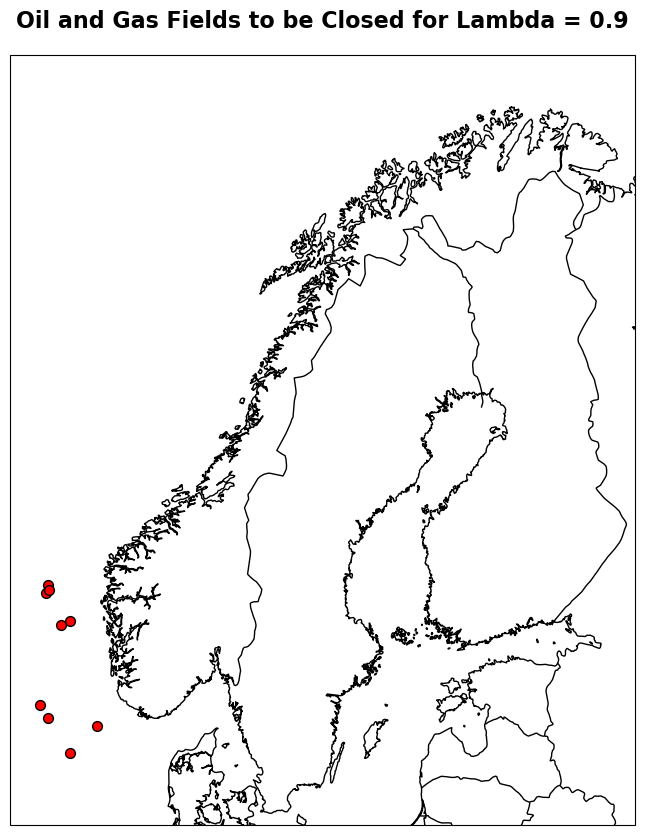

In [637]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd


def plot_closed_fields_cartopy_adjusted(
    results, lambda_value, lifetime_pred_optimized_df
):
    # Filter the results for the given lambda value
    df = results[lambda_value]
    fields_closed = df[df["optimized_production"] == 0]["field"].unique()

    # Filter the lifetime_pred_optimized_df to get the geometries of the fields to be closed
    closed_fields_geometry = lifetime_pred_optimized_df[
        lifetime_pred_optimized_df["field"].isin(fields_closed)
    ]

    # Create a new plot with Cartopy
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": ccrs.Mercator()})

    # Add coastlines and borders for context
    ax.coastlines(resolution="10m", color="black", linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=1)

    # Plot the base map using the geometries (in gray)
    lifetime_pred_optimized_df = lifetime_pred_optimized_df.to_crs(
        ccrs.Mercator().proj4_init
    )
    lifetime_pred_optimized_df.boundary.plot(
        ax=ax, edgecolor="lightgray", linewidth=0.5
    )

    # Plot the closed fields (in red)
    closed_fields_geometry = closed_fields_geometry.to_crs(ccrs.Mercator().proj4_init)
    closed_fields_geometry.plot(
        ax=ax, color="red", edgecolor="black", markersize=50, marker="o"
    )

    # Set title with professional styling
    plt.title(
        f"Oil and Gas Fields to be Closed for Lambda = {lambda_value}",
        fontsize=16,
        fontweight="bold",
        pad=20,
    )

    # Set extent to the area of interest
    ax.set_extent([0, 32, 55, 72], crs=ccrs.PlateCarree())

    # Show the plot
    plt.show()


plot_closed_fields_cartopy_adjusted(results, 0.9, lifetime_pred_optimized_df)
